In [1]:
# ------- SERVER EXTENSIONS ---------
lib =  r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities/droplet_dataset'
lib2 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/utilities'
lib3 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/data_analysis'
lib4 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy'
lib5 = r'/srv01/technion/shitay/Code/classifying_response_to_immunotherapy/scripts'
import sys
sys.path.append(lib)
sys.path.append(lib2)
sys.path.append(lib3)
sys.path.append(lib4)
sys.path.append(lib5)
# ------- SERVER EXTENSIONS ---------import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn.manifold import TSNE
import pickle
# from Bio.Cluster import kcluster
import os
import numpy as np
import yaml
import os
import pandas
from collections import Counter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import sys
import seaborn as sns
# import pyclustering
import matplotlib.pylab as plt
import seaborn as sb
from os.path import join
plt.rcParams['figure.dpi'] = 400
import seaborn as sns
from utilities.general_helpers import sort_dic
from utilities.general_helpers import transpose

from shutil import copyfile
import matplotlib.pyplot as plt
import random


Loads cohort and extract tumor cells:

In [2]:
# tumor_path = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/5.21/cohort_normalized_24.5.21.pkl'
COHORT_PATH = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/6.21/cohort_normalized_26.6.21.pkl'

# tumor_cohort = pickle.load(open(tumor_path, 'rb'))
cohort = pickle.load(open(COHORT_PATH, 'rb'))
tumor_cohort = cohort.filter_cells_by_property('is_cancer', True)



Loads tSNE:

In [3]:
TSNE_PATH = r'/storage/md_keren/shitay/outputs/TSNE/cohort_10.6.21/tumor_cells_bhtsne_14.6.21.pkl'
cells_embedded = pickle.load(open(TSNE_PATH, 'rb'))


# tsne_results = pd.DataFrame(cells_embedded, index=tumor_cohort.barcodes, columns=['TSNE1', 'TSNE2'])
index = [tumor_cohort.samples[i]+"_"+tumor_cohort.barcodes[i] for i in range(tumor_cohort.number_of_cells)]
tsne_results = pd.DataFrame(cells_embedded, index=index, columns=['TSNE1', 'TSNE2']) 

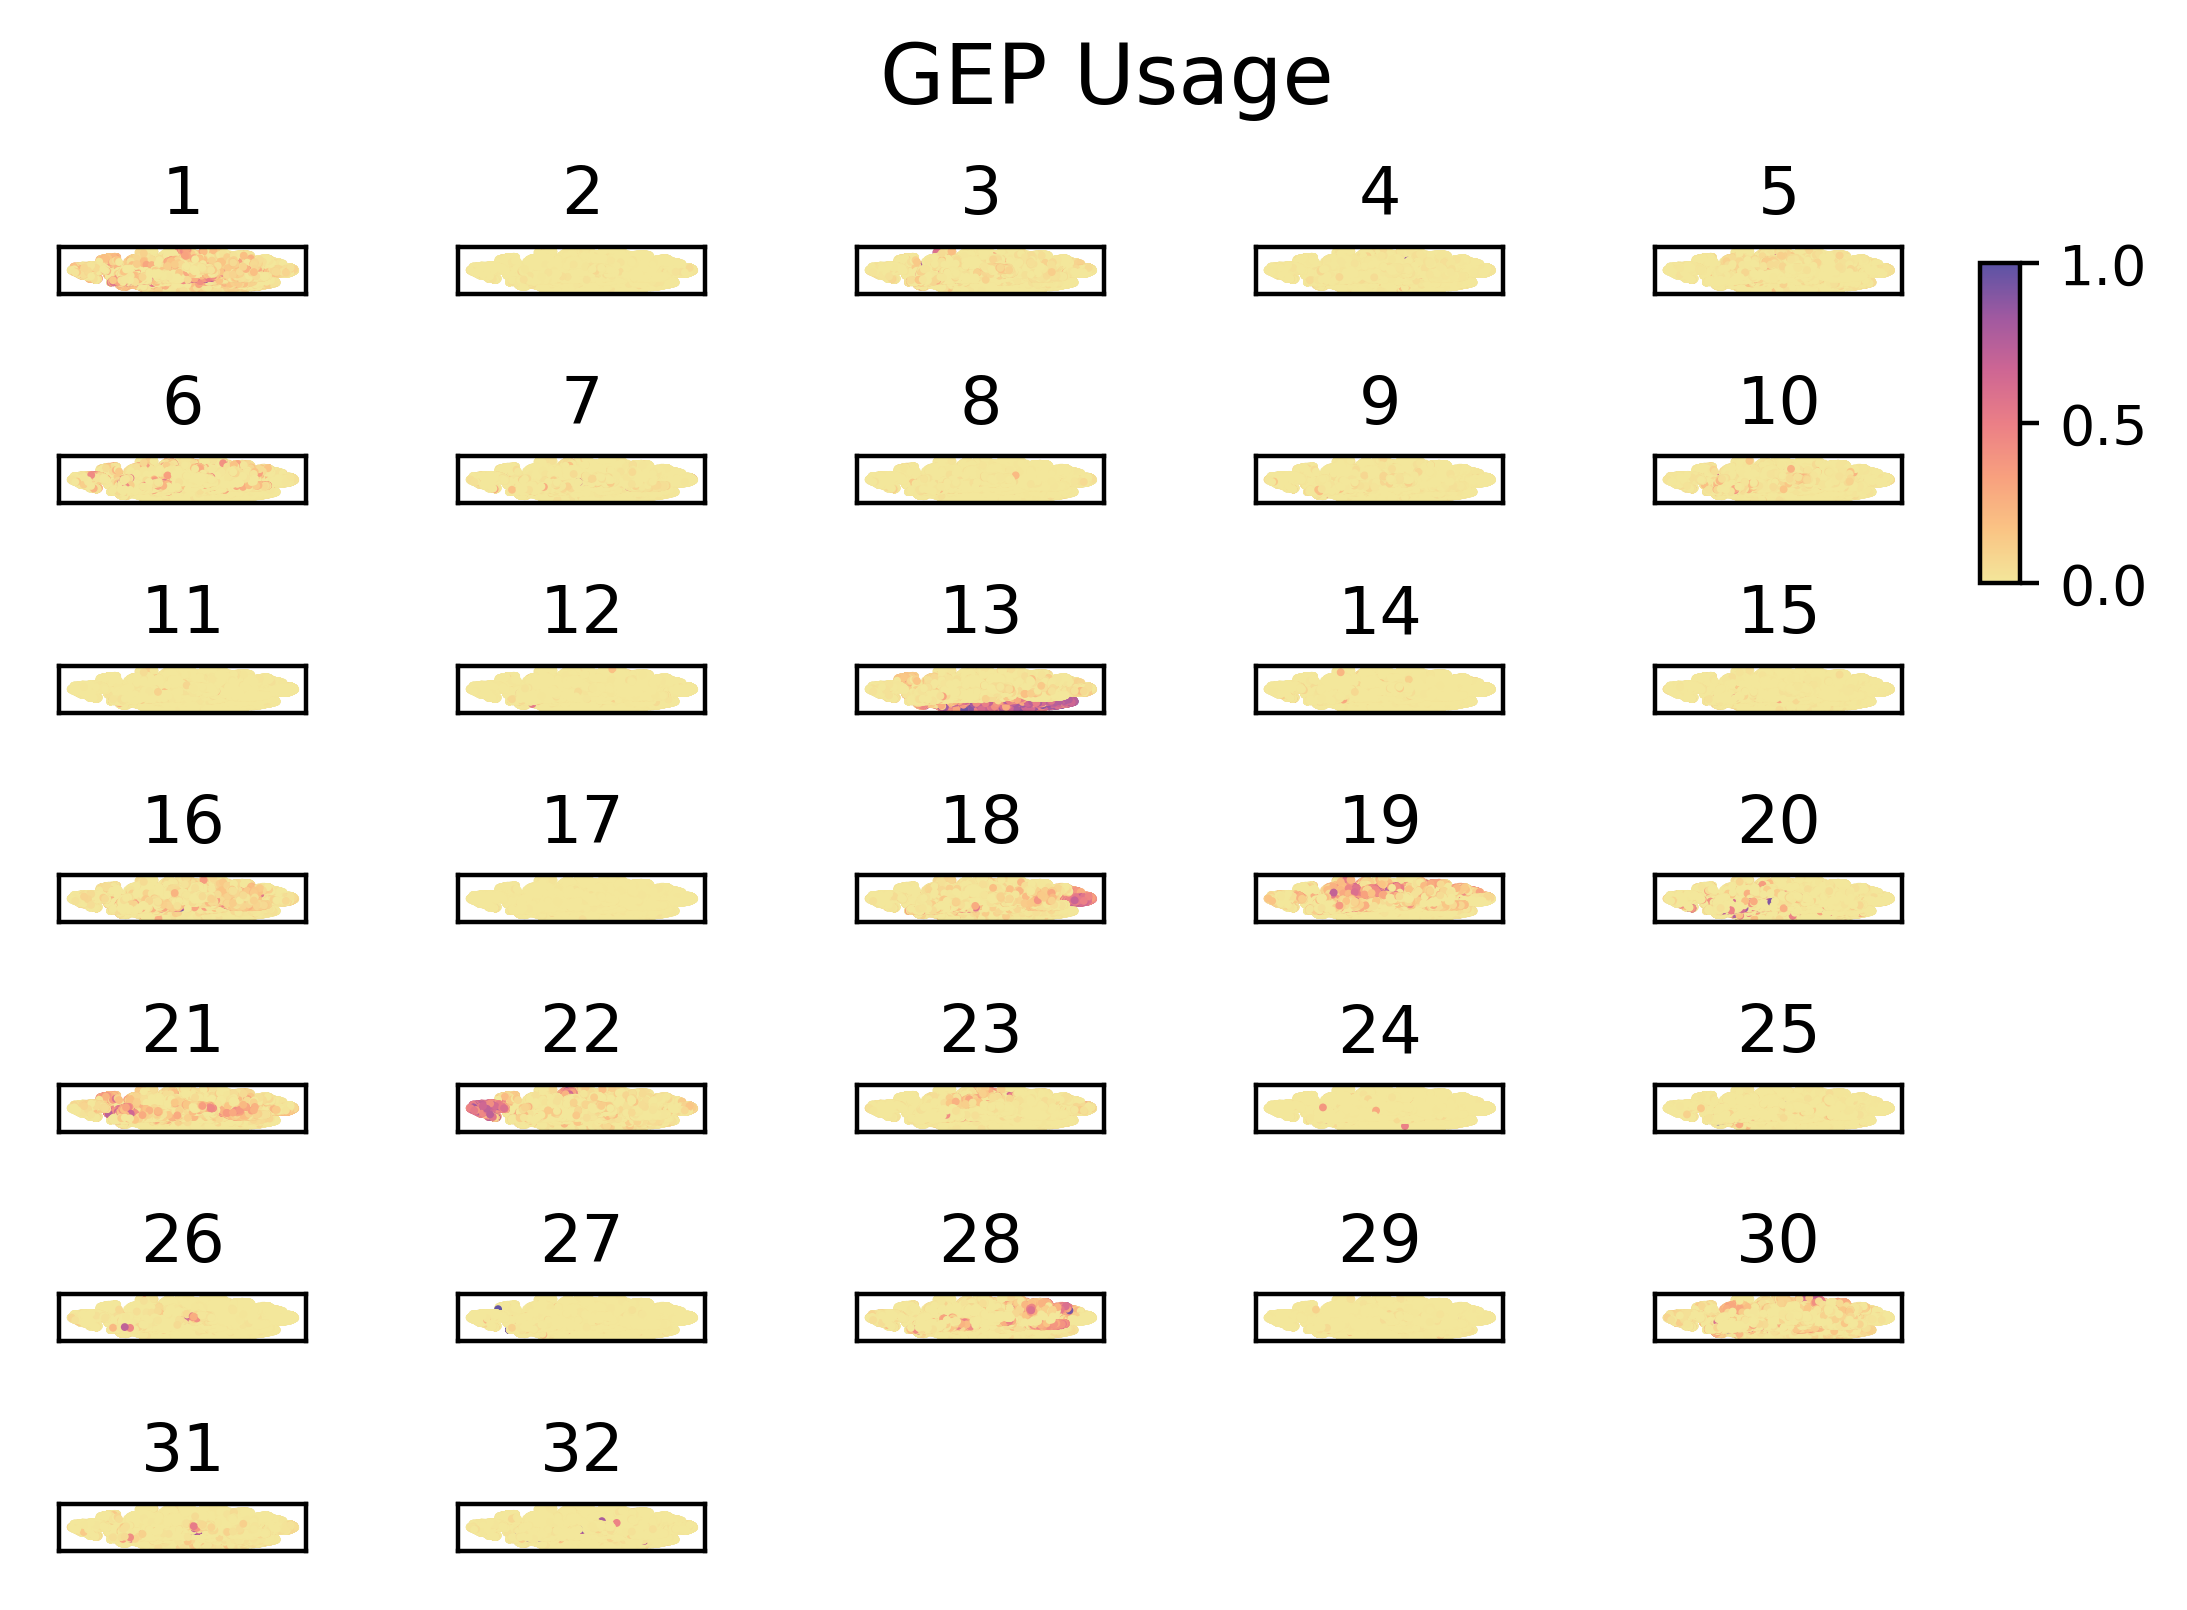

In [42]:
EXEC_DIR = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_26.6.21'
selected_K = 32
local_density_threshold = '0.10'
number_of_genes=2000
n_replicates = 10
RUN_RANGE = '26_40'

RUN_NAME = f'k{RUN_RANGE}_{number_of_genes}genes_{n_replicates}iter'
USAGES_CONSENSUS_FILE = f'{RUN_NAME}.usages.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.consensus.txt'


usage_matrix = pd.read_csv(join(EXEC_DIR, RUN_NAME, USAGES_CONSENSUS_FILE), sep='\t', index_col=0)
usage_matrix.columns = np.arange(1,selected_K+1)
normalized_usage_matrix = usage_matrix.div(usage_matrix.sum(axis=1), axis=0)
normalized_usage_matrix.head()


cmap = pickle.load(open(r'/storage/md_keren/shitay/garbage/cmap.pkl', 'rb'))
tsne_and_usages = pd.merge(left=normalized_usage_matrix, right=tsne_results, left_index=True, right_index=True)



(fig,axes) = plt.subplots(int(np.ceil(selected_K/5)), 5, figsize=(5,4), dpi=400)
axes = axes.ravel()
for i in range(1, selected_K+1):
    sc = axes[i-1].scatter(tsne_and_usages['TSNE1'], tsne_and_usages['TSNE2'], c=tsne_and_usages[i],
                      cmap=cmap, vmin=0, vmax=1.,
                      s=2, edgecolor='none', rasterized=True)
    axes[i-1].set_title(i)
    axes[i-1].set_xticks([])
    axes[i-1].set_yticks([])
    
    
    

plt.tight_layout()
cbarax = fig.add_axes([1,.7,.02, .2])
plt.colorbar(sc, cax=cbarax)
_ = plt.figtext(.45,1,'GEP Usage', fontsize=15)
if selected_K%5>0:
    for i in range(5-selected_K%5, 0, -1):
        axes[-i].remove()

In [43]:
fig.savefig(fr'/storage/md_keren/shitay/outputs/cNMF/visualizations/cohort_26.6.21/k{selected_K}/tSNE_GEP.png')

We might also want to investigate which genes are driving which programs. We can do so by loading the Z-score transformed spectra and sorting it as follows

In [34]:
GENE_SPECTRA_SCORE_PATH = f'{RUN_NAME}.gene_spectra_score.k_{selected_K}.dt_{str(local_density_threshold).replace(".", "_")}.txt'
gene_scores = pd.read_csv(join(EXEC_DIR, RUN_NAME, GENE_SPECTRA_SCORE_PATH), sep='\t', index_col=0)
gene_scores = gene_scores.T
gene_scores.head()

1         2         3         4         5         6   \
TSPAN6   -0.000075 -0.000080 -0.000577  0.000018 -0.000079 -0.000004   
TNMD      0.000033 -0.000042 -0.000109  0.000022 -0.000352  0.000948   
DPM1      0.000076  0.000092  0.000081 -0.000047 -0.000062  0.000091   
SCYL3    -0.000008 -0.000011 -0.000205  0.000322 -0.000047  0.000014   
C1orf112  0.000087 -0.000080 -0.000305 -0.000063 -0.000037 -0.000145   

                7         8         9         10  ...        17        18  \
TSPAN6   -0.000200  0.000184 -0.000161 -0.000191  ... -0.000066  0.000046   
TNMD     -0.000048  0.000153  0.000055 -0.000059  ... -0.000002  0.000045   
DPM1     -0.000038 -0.000046 -0.000071 -0.000139  ... -0.000005  0.000442   
SCYL3    -0.000013 -0.000012  0.000249  0.000030  ...  0.000030  0.000228   
C1orf112  0.000173 -0.000020 -0.000006 -0.000068  ... -0.000035 -0.000109   

                19            20        21        22        23        24  \
TSPAN6    0.000204  2.958725e-04  0.000033 -0.000144 -0.000004 -0.000097   
TNMD     -0.000101  9.877262e-07 -0.000003 -0.000084  0.000733 -0.000005   
DPM1      0.000030  3.370634e-04 -0.000041 -0.000778 -0.000060 -0.000056   
SCYL3    -0.000040  1.689647e-04 -0.000123  0.000016 -0.000049 -0.000005   
C1orf112 -0.000066  1.724853e-05 -0.000068 -0.000397 -0.000086  0.000008   

                25        26  
TSPAN6   -0.000008  0.000403  
TNMD     -0.000012  0.000408  
DPM1     -0.000032 -0.000018  
SCYL3     0.000011 -0.000065  
C1orf112  0.000029 -0.000023  

[5 rows x 26 columns]

# Below we plot the top 10 genes associated with each gene expression program


In [35]:
topgenes = []
num_top_genes=100
for gep in gene_scores.columns:
    topgenes.append(pd.Series(gene_scores[gep].sort_values(ascending=False).index[:num_top_genes]))
    
topgenes = pd.concat(topgenes, axis=1)
topgenes.columns = ['GEP%d' % g for g in gene_scores.columns]

topgenes.head(10)

GEP1     GEP2       GEP3      GEP4     GEP5   GEP6      GEP7  \
0      MAGEB3  RARRES2     S100A6      AMBP   COL1A1  TAGLN      MZB1   
1       KISS1    CTAG2   SH3BGRL3      RBP4   COL1A2  ACTA2     DERL3   
2        RTL1     LY6K  TNFRSF12A       ALB   COL5A1   MYL9     CD79A   
3     SCGB2A2   PAGE2B   SERPINE2     APOA1   COL3A1  ADIRF  TNFRSF17   
4       KLK15     CTSZ     LGALS1     APOA2    POSTN  MYH11     FCRL5   
5  AC102948.2    PAGE2      LYPD1  SERPINA1    MXRA5   CNN1       IGJ   
6        IRX4   MAGEA4      HMGA1       HRG   COL6A3   TPM1      XBP1   
7        OC90    PNMA5     DCBLD2     APOC3    SPARC   TPM2      PIM2   
8       KRT19    GTSF1       NGFR      AHSG  COL12A1  LMOD1      CD27   
9      MTNR1B    HLA-A        PKM      APOH   COL5A2  FOXS1     JSRP1   

      GEP8     GEP9   GEP10  ...     GEP17     GEP18   GEP19    GEP20  \
0    PLVAP    APLP1  TYROBP  ...      LY6D  HLA-DPA1    PMEL      PTN   
1     CD93      MOG    AIF1  ...     KRT6A       B2M  LGALS3     CCT2   
2    RAMP3    CNTN2    C1QC  ...    CALML3      CD74   ATOX1    RAP1B   
3      ENG   SLAIN1  TMSB4X  ...     KRT16   TMEM171   WFDC1      TNN   
4  CLEC14A   NKX6-2  FCER1G  ...  C10orf99    CXCL10    CAPG     OTOR   
5     CDH5     KLK6  LAPTM5  ...   LGALS7B  HLA-DRB5   WIPI1     CHN1   
6    HSPG2   CLDN11    C1QB  ...     KRT6B   RARRES3   GSTP1      FST   
7     ESAM     PLP1    C1QA  ...     KRT6C   HLA-DRA   MLANA    ITIH5   
8    ELTD1  HEPACAM     LYZ  ...       IVL      IRF1    CTSL    CPSF6   
9      VWF  SLC24A2  MS4A6A  ...     KRT14      GBP1   TRPM1  GAGE12J   

      GEP21     GEP22   GEP23     GEP24     GEP25   GEP26  
0      RHAG     FXYD3   MFAP5  C10orf71     GREM1   MMRN1  
1      HBG2     RPL39     CFD     TSPY8      MMP1    TFF3  
2  C1orf141    FCGR2A     DCN      MYOG      CSF2   STAB2  
3    TPSAB1    RPS4Y1    TNXB     TNNI1      CSF3    TFPI  
4      CPA3     RPL15   FSTL1      MYL1     CXCL5  EFEMP1  
5       CA1     RPS14   FBLN2    TMEM8C     CXCL3   CCL21  
6      HBG1  SIGLEC15    FBN1     MYBPH  SERPINB4   ECSCR  
7       HDC    CHCHD6  SCARA5   APOBEC2     CXCL1    PDPN  
8   SLC18A2     RPL14   CD248     ACTA1       IL8  ANGPT2  
9     TPSD1     RPS23  CLEC3B     TNNC2      MMP3   FABP4  

[10 rows x 26 columns]

In [36]:
topgenes.to_excel(fr'/storage/md_keren/shitay/outputs/cNMF/visualizations/cohort_26.6.21/k{selected_K}/GEP_top_100_genes.xlsx')

In [37]:
tsne_and_usages.head()

1         2         3    4    5         6  \
M100_AAACCTGAGAAACCAT-1  0.0  0.018583  0.000000  0.0  0.0  0.003759   
M100_AAACCTGAGACGCAAC-1  0.0  0.063318  0.185071  0.0  0.0  0.010853   
M100_AAACCTGAGGATTCGG-1  0.0  0.018875  0.000000  0.0  0.0  0.000000   
M100_AAACCTGAGGGCATGT-1  0.0  0.059362  0.092494  0.0  0.0  0.000000   
M100_AAACCTGCACGAGAGT-1  0.0  0.027580  0.015139  0.0  0.0  0.000000   

                                7    8         9        10  ...        19  \
M100_AAACCTGAGAAACCAT-1  0.000000  0.0  0.013735  0.043977  ...  0.197797   
M100_AAACCTGAGACGCAAC-1  0.000000  0.0  0.018628  0.000000  ...  0.163690   
M100_AAACCTGAGGATTCGG-1  0.000000  0.0  0.017997  0.000000  ...  0.499556   
M100_AAACCTGAGGGCATGT-1  0.000000  0.0  0.010086  0.000000  ...  0.124493   
M100_AAACCTGCACGAGAGT-1  0.004735  0.0  0.000000  0.002366  ...  0.229496   

                               20        21        22        23        24  \
M100_AAACCTGAGAAACCAT-1  0.044567  0.000000  0.344062  0.000000  0.000497   
M100_AAACCTGAGACGCAAC-1  0.030748  0.004821  0.248670  0.000000  0.000796   
M100_AAACCTGAGGATTCGG-1  0.000000  0.026128  0.311574  0.000000  0.000000   
M100_AAACCTGAGGGCATGT-1  0.031044  0.039867  0.213441  0.000000  0.004977   
M100_AAACCTGCACGAGAGT-1  0.003552  0.005413  0.256910  0.024183  0.000000   

                          25        26      TSNE1     TSNE2  
M100_AAACCTGAGAAACCAT-1  0.0  0.000000  10.707614  3.967761  
M100_AAACCTGAGACGCAAC-1  0.0  0.000000  10.550479  3.919449  
M100_AAACCTGAGGATTCGG-1  0.0  0.000000  13.603993  8.250690  
M100_AAACCTGAGGGCATGT-1  0.0  0.000000   9.053694  3.274416  
M100_AAACCTGCACGAGAGT-1  0.0  0.020151  10.318816  7.193634  

[5 rows x 28 columns]

# Visualization

In [38]:
normalized_usage_matrix.head()
normalized_usage_matrix.iloc[['1']]
# normalized_usage_matrix
samples = list(set([uu.split('_')[0] for uu in list(normalized_usage_matrix.index)]))


total sum expression of samples in program

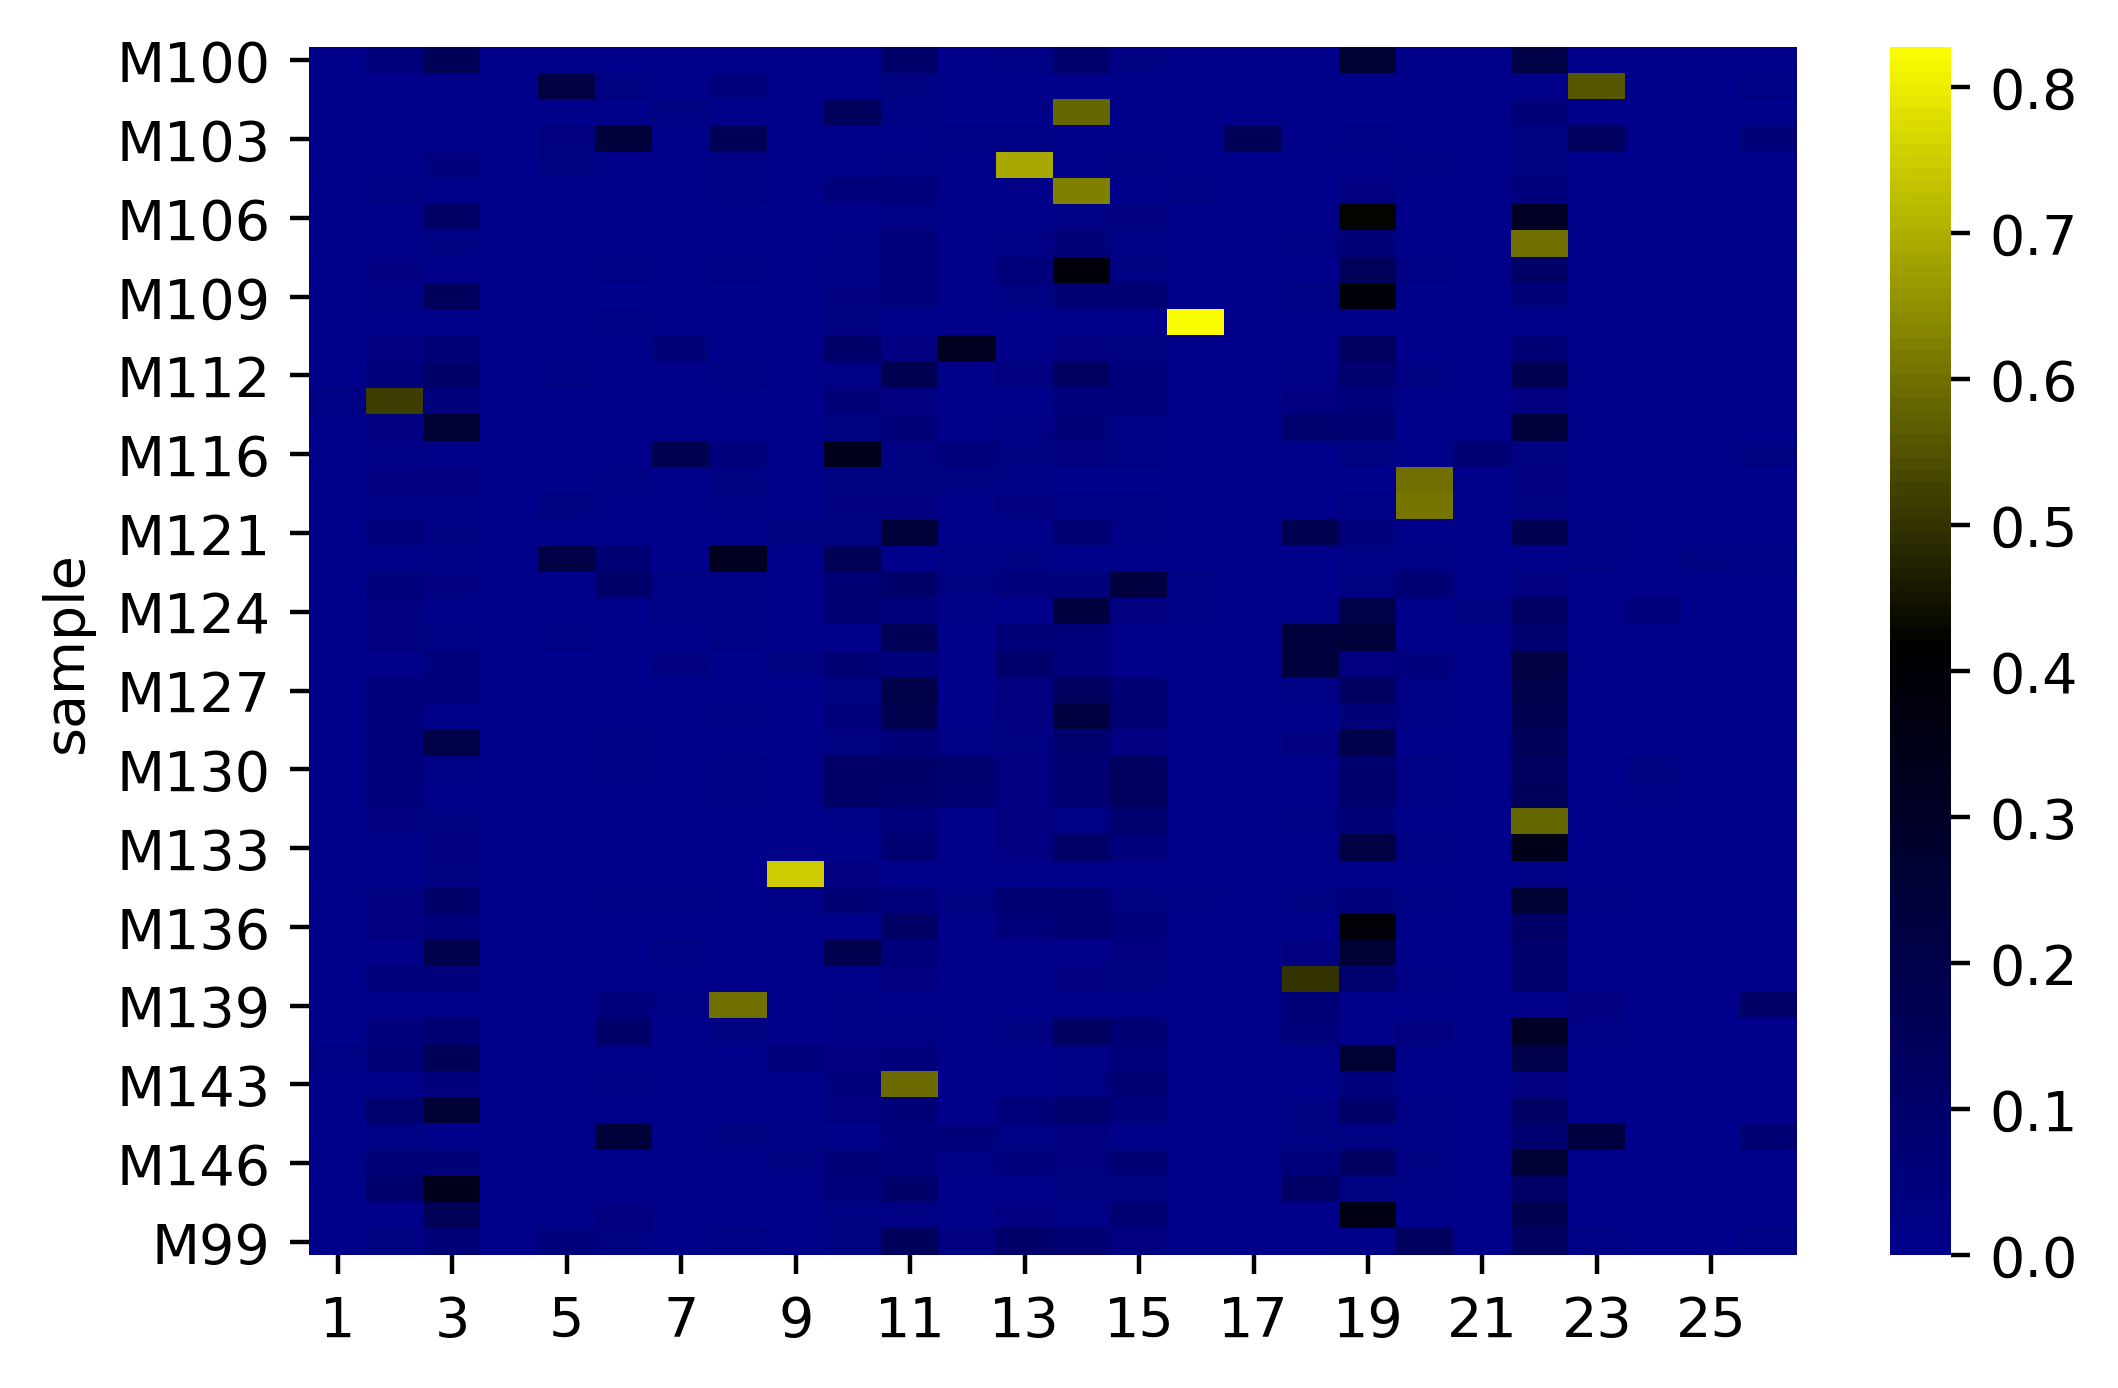

In [39]:
import seaborn as sb
df = normalized_usage_matrix.copy()
df['sample'] = [uu.split('_')[0] for uu in list(df.index)]
df['barcode'] = [uu.split('_')[1] for uu in list(df.index)]
df = df.set_index(['sample', 'barcode'])
samples_programs_prop = df.groupby(['sample']).sum() / df.groupby(['sample']).count()
cmap = pickle.load(open(r'/storage/md_keren/shitay/outputs/clustering/heatmap/colorbar.pkl', 'rb'))
sb.heatmap(samples_programs_prop, cmap=cmap);

Specify a a threshold of min expression for cell in a program, and see the percentage of cells expresing each program for all samples

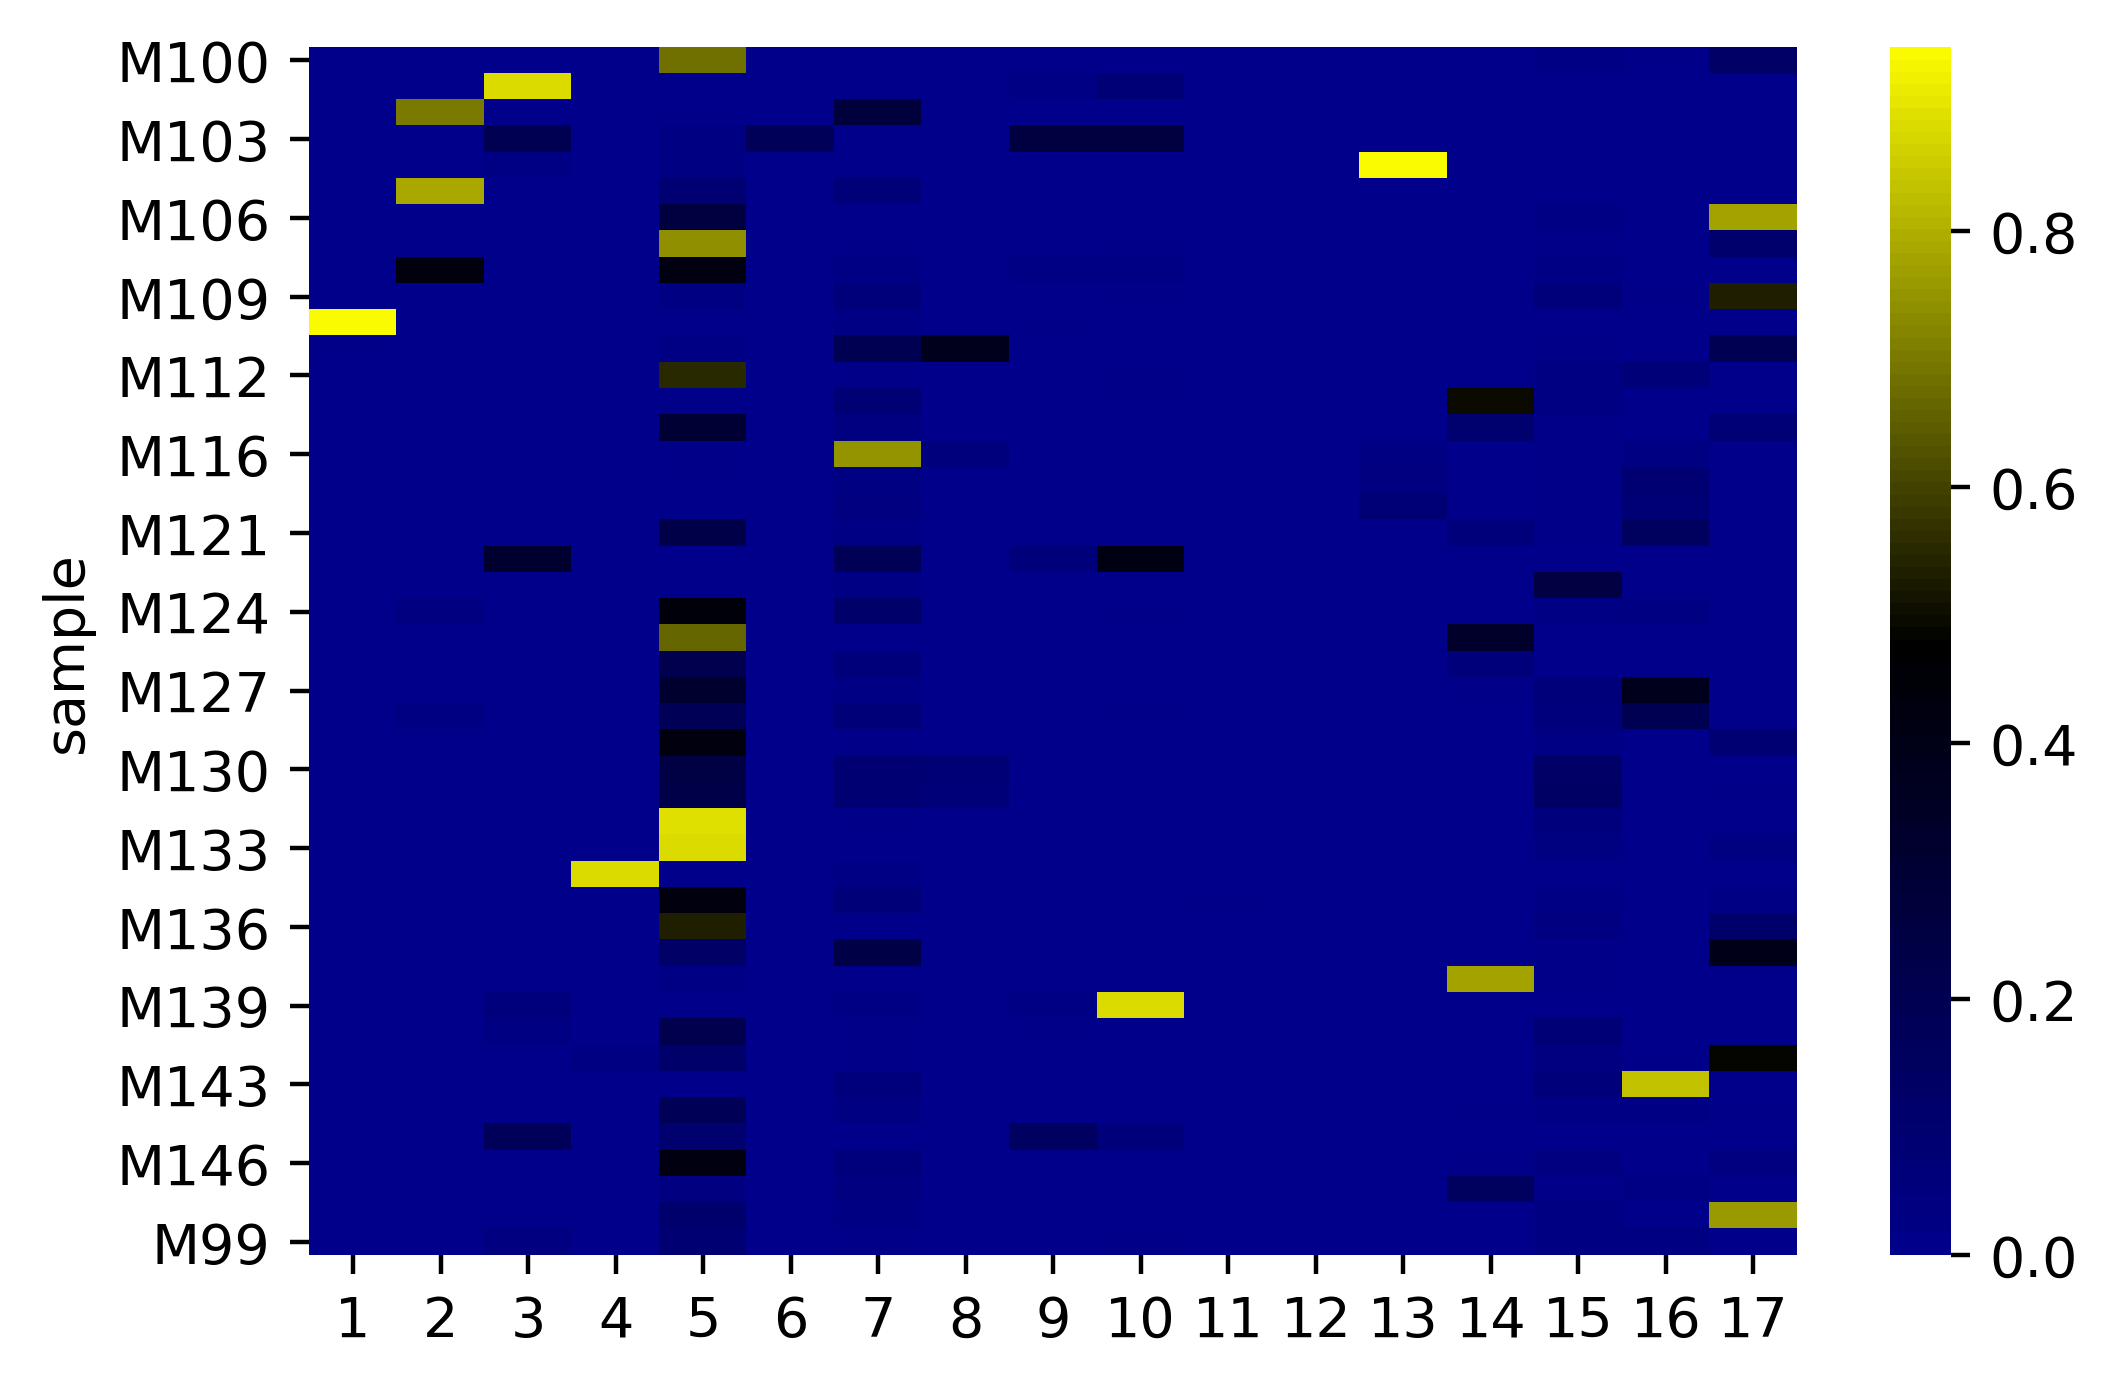

In [12]:
min_expression_to_be_counted = 0.4

df2 = df > min_expression_to_be_counted
portion_expressing_programs = df2.groupby(['sample']).sum() / df2.groupby(['sample']).count()
sb.heatmap(portion_expressing_programs, cmap=cmap);

See all thresholds of min expression for being counted

In [40]:
# fig, axs = plt.subplots(ncols=3, gridspec_kw=dict(width_ratios=[4,1,0.2]))
# fig, axs = plt.subplots(ncols=3)
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(32, 22)
# sb.heatmap(portion_expressing_programs, cmap=cmap, ax=axs[0,0]);
# sb.heatmap(portion_expressing_programs, cmap=cmap, ax=axs[1,0]);
import itertools
index = [(x,y) for x in np.arange(3) for y in np.arange(3)]


for i in range(9):
    min_expression_to_be_counted = round(0.1 * (i+1),2)
    df2 = df > min_expression_to_be_counted
    portion_expressing_programs = df2.groupby(['sample']).sum() / df2.groupby(['sample']).count()
    axs[index[i][0], index[i][1]].set_title(f"Threshold - {min_expression_to_be_counted}")
    sb.heatmap(portion_expressing_programs, cmap=cmap, ax=axs[index[i][0], index[i][1]]);

In [41]:
fig.savefig(fr'/storage/md_keren/shitay/outputs/cNMF/visualizations/cohort_26.6.21/k{selected_K}/different_expression_thresholds.jpg')

# DIsplaying programs information
* see how many cells are assocatied with each program
* see which samples


In [15]:
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}%'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)


In [16]:
selected_K = 17
fig, axs = plt.subplots(int(np.ceil(selected_K/5)), 5)
axs = axs.ravel()

fig.set_size_inches(32, 22)
for idx, (columnName, columnData) in enumerate(normalized_usage_matrix.iteritems()):
#     print('Program : ', columnName)
    programs_vals = columnData.values
    df = pd.DataFrame(np.round(programs_vals, 1),columns=['Usage'])
    g = sns.barplot(x="Usage", y="Usage", data=df, estimator=lambda x: len(x) / len(df) * 100, ax=axs[idx]);
    g.set(ylabel="% of the cells");
    g.set_title(f'Program {columnName}')
    show_values_on_bars(g)
fig.tight_layout()
if selected_K%5>0:
    for i in range(5-selected_K%5, 0, -1):
        axs[-i].remove()

In [17]:
# fig.savefig(fr'/storage/md_keren/shitay/outputs/cNMF/visualizations/k{selected_K}/cell_usages.jpg')


see how many cells are assocatied with each program.

each usage value you see the number of cells with that usage or more (the usage value are rounded).

the programs are sorted by the value of number of cells with 0.1 usage or more.

In [ ]:
programs_dfs = {}

for column in normalized_usage_matrix.columns:

    programs_vals = np.round(normalized_usage_matrix[column].values, 1)
    curr_program_usage = pd.DataFrame([x/10 for x in range(11)], columns=['Usage'])
    curr_program_usage['val'] = curr_program_usage['Usage'].apply(lambda x: (sum(programs_vals>=x)/len(programs_vals))*100)
    programs_dfs[column] = curr_program_usage
programs_dfs = {k: v for k, v in sorted(programs_dfs.items(), key=lambda item: item[1].iloc[1].val, reverse=True)}

fig, axs = plt.subplots(int(np.ceil(selected_K/5)), 5)
axs = axs.ravel()

fig.set_size_inches(32, 22)
for idx, (columnName, program_df) in enumerate(programs_dfs.items()):
    g = sns.barplot(x="Usage", y="val", data=program_df, ax=axs[idx])#, estimator=lambda x: len(x) / len(df) * 100, ax=axs[idx]);    
    g.set(ylabel="% of the cells");
    g.set_title(f'Program {columnName}')
    show_values_on_bars(g)
fig.tight_layout()
if selected_K%5>0:
    for i in range(5-selected_K%5, 0, -1):
        axs[-i].remove()

# Anaylize cells in program

**specify program num and threshold and see how many cells express this program > threshold in each sample**

In [18]:
program_num = 5
threshold = 0.8

# taks normalized_usage_matrix and change id of df
usage_matrix = normalized_usage_matrix.copy()
usage_matrix['sample'] = [uu.split('_')[0] for uu in list(usage_matrix.index)]
usage_matrix['barcode'] = [uu.split('_')[1] for uu in list(usage_matrix.index)]
usage_matrix = usage_matrix.set_index(['sample', 'barcode']).reset_index()

total_n_cells = sum(usage_matrix[program_num]>threshold)/ len(usage_matrix)
n_cells_in_each_sample = usage_matrix[usage_matrix[program_num]>threshold].groupby(['sample']).count().reset_index()[['sample','barcode']].values.tolist()
print(n_cells_in_each_sample)

[['M100', 159], ['M105', 38], ['M106', 64], ['M107', 1138], ['M108', 101], ['M109', 2], ['M112', 69], ['M115', 5], ['M118', 4], ['M124', 1], ['M127', 2], ['M128', 2], ['M129', 16], ['M132', 305], ['M133', 471], ['M135', 3], ['M136', 2], ['M137', 5], ['M141', 2], ['M144', 23], ['M145', 7], ['M146', 7], ['M98', 9], ['M99', 1]]


 **Extract cells with high usage and cells with low usage of a given program**
 
 cells with high usage - usage above top_usage_thr, cells with low usage - usage below lower_usage_thr
 
 Part1: See what part of the of top genes (of a given program) reads make up of the total amount of reads (cells with high usage VS. cells with low usage)
 
Part2: Present boxplots of top genes expression of a given program

- previous version was for a specific sample now it works for all samples. you can turn it on by removing the comment of three lines that are marked

In [19]:
GEP = 5
top_usage_thr = 0.8
lower_usage_thr = 0.2


# previous version - return this line (and the next three marked lines) if you want it to be only for that sample
# sample_id = 'M133' 

# extract sample
sample_cells = tumor_cohort
# sample_cells = tumor_cohort[np.array(tumor_cohort.samples)==sample_id] # (line 1.) previous version - return this line if you want it to be only for that sample


# taks all cells express GEP above up_threshold
high_expressed_df = usage_matrix[usage_matrix[GEP]>top_usage_thr]
sample_cells_in_program_df = high_expressed_df # compare all samples

# taks all cells belong to sample_id # previous version - return this line if you want it to be only for that sample
# sample_cells_in_program_df = high_expressed_df[high_expressed_df['sample']==sample_id] # (line 2.) previous version - return this line if you want it to be only for that sample

# extract droplet python object of those cells belong to sample one object of cells above threshold and the second below
sample_cells_highly_express_program = tumor_cohort.get_subset_by_identifiers(sample_cells_in_program_df['sample'], sample_cells_in_program_df['barcode'])
# sample_cells_out_program = tumor_cohort[[idx for idx, bb in enumerate(sample_cells.barcodes) if not bb in list(sample_cells_in_program_df['barcode'])]]



# taks all cells express GEP below down_threshold
low_expressed_df = usage_matrix[usage_matrix[GEP]<=lower_usage_thr]
sample_cells_not_in_program_df = low_expressed_df # compare all samples
# taks all cells belong to sample_id # previous version - return this line if you want it to be only for that sample
# sample_cells_not_in_program_df = low_expressed_df[low_expressed_df['sample']==sample_id] # (line 3.) previous version - return this line if you want it to be only for that sample

# extract droplet python object of those cells belong to sample one object of cells above threshold and the second below
sample_cells_out_program = tumor_cohort.get_subset_by_identifiers(sample_cells_not_in_program_df['sample'], sample_cells_not_in_program_df['barcode'])



# print(f'number of cells in sample {sample_id}: {sample_cells.number_of_cells}')
# print(f'number of cells in sample {sample_id} use GEP {GEP} above {top_usage_thr}: {sample_cells_highly_express_program.number_of_cells}')
# print(f'number of cells in sample {sample_id} use GEP {GEP} below {lower_usage_thr}: {sample_cells_out_program.number_of_cells}')

print(f'number of cells (all samples): {sample_cells.number_of_cells}')
print(f'number of cells (all samples) use GEP {GEP} above {top_usage_thr}: {sample_cells_highly_express_program.number_of_cells}')
print(f'number of cells (all samples) use GEP {GEP} below {lower_usage_thr}: {sample_cells_out_program.number_of_cells}')

number of cells (all samples): 104935
number of cells (all samples) use GEP 5 above 0.8: 2436
number of cells (all samples) use GEP 5 below 0.2: 53290


**Part1: see what part of the of top genes (of a given program) reads make up of the total amount of reads (cells with high usage VS. cells with low usage):**


In [20]:
# sort genes by scores
top_genes_in_program = pd.Series(gene_scores[GEP].sort_values(ascending=False).index).tolist()
top_genes_indices = [tumor_cohort.gene_names.index(gene) for gene in top_genes_in_program if gene in tumor_cohort.gene_names]


<Figure size 6400x4000 with 0 Axes>

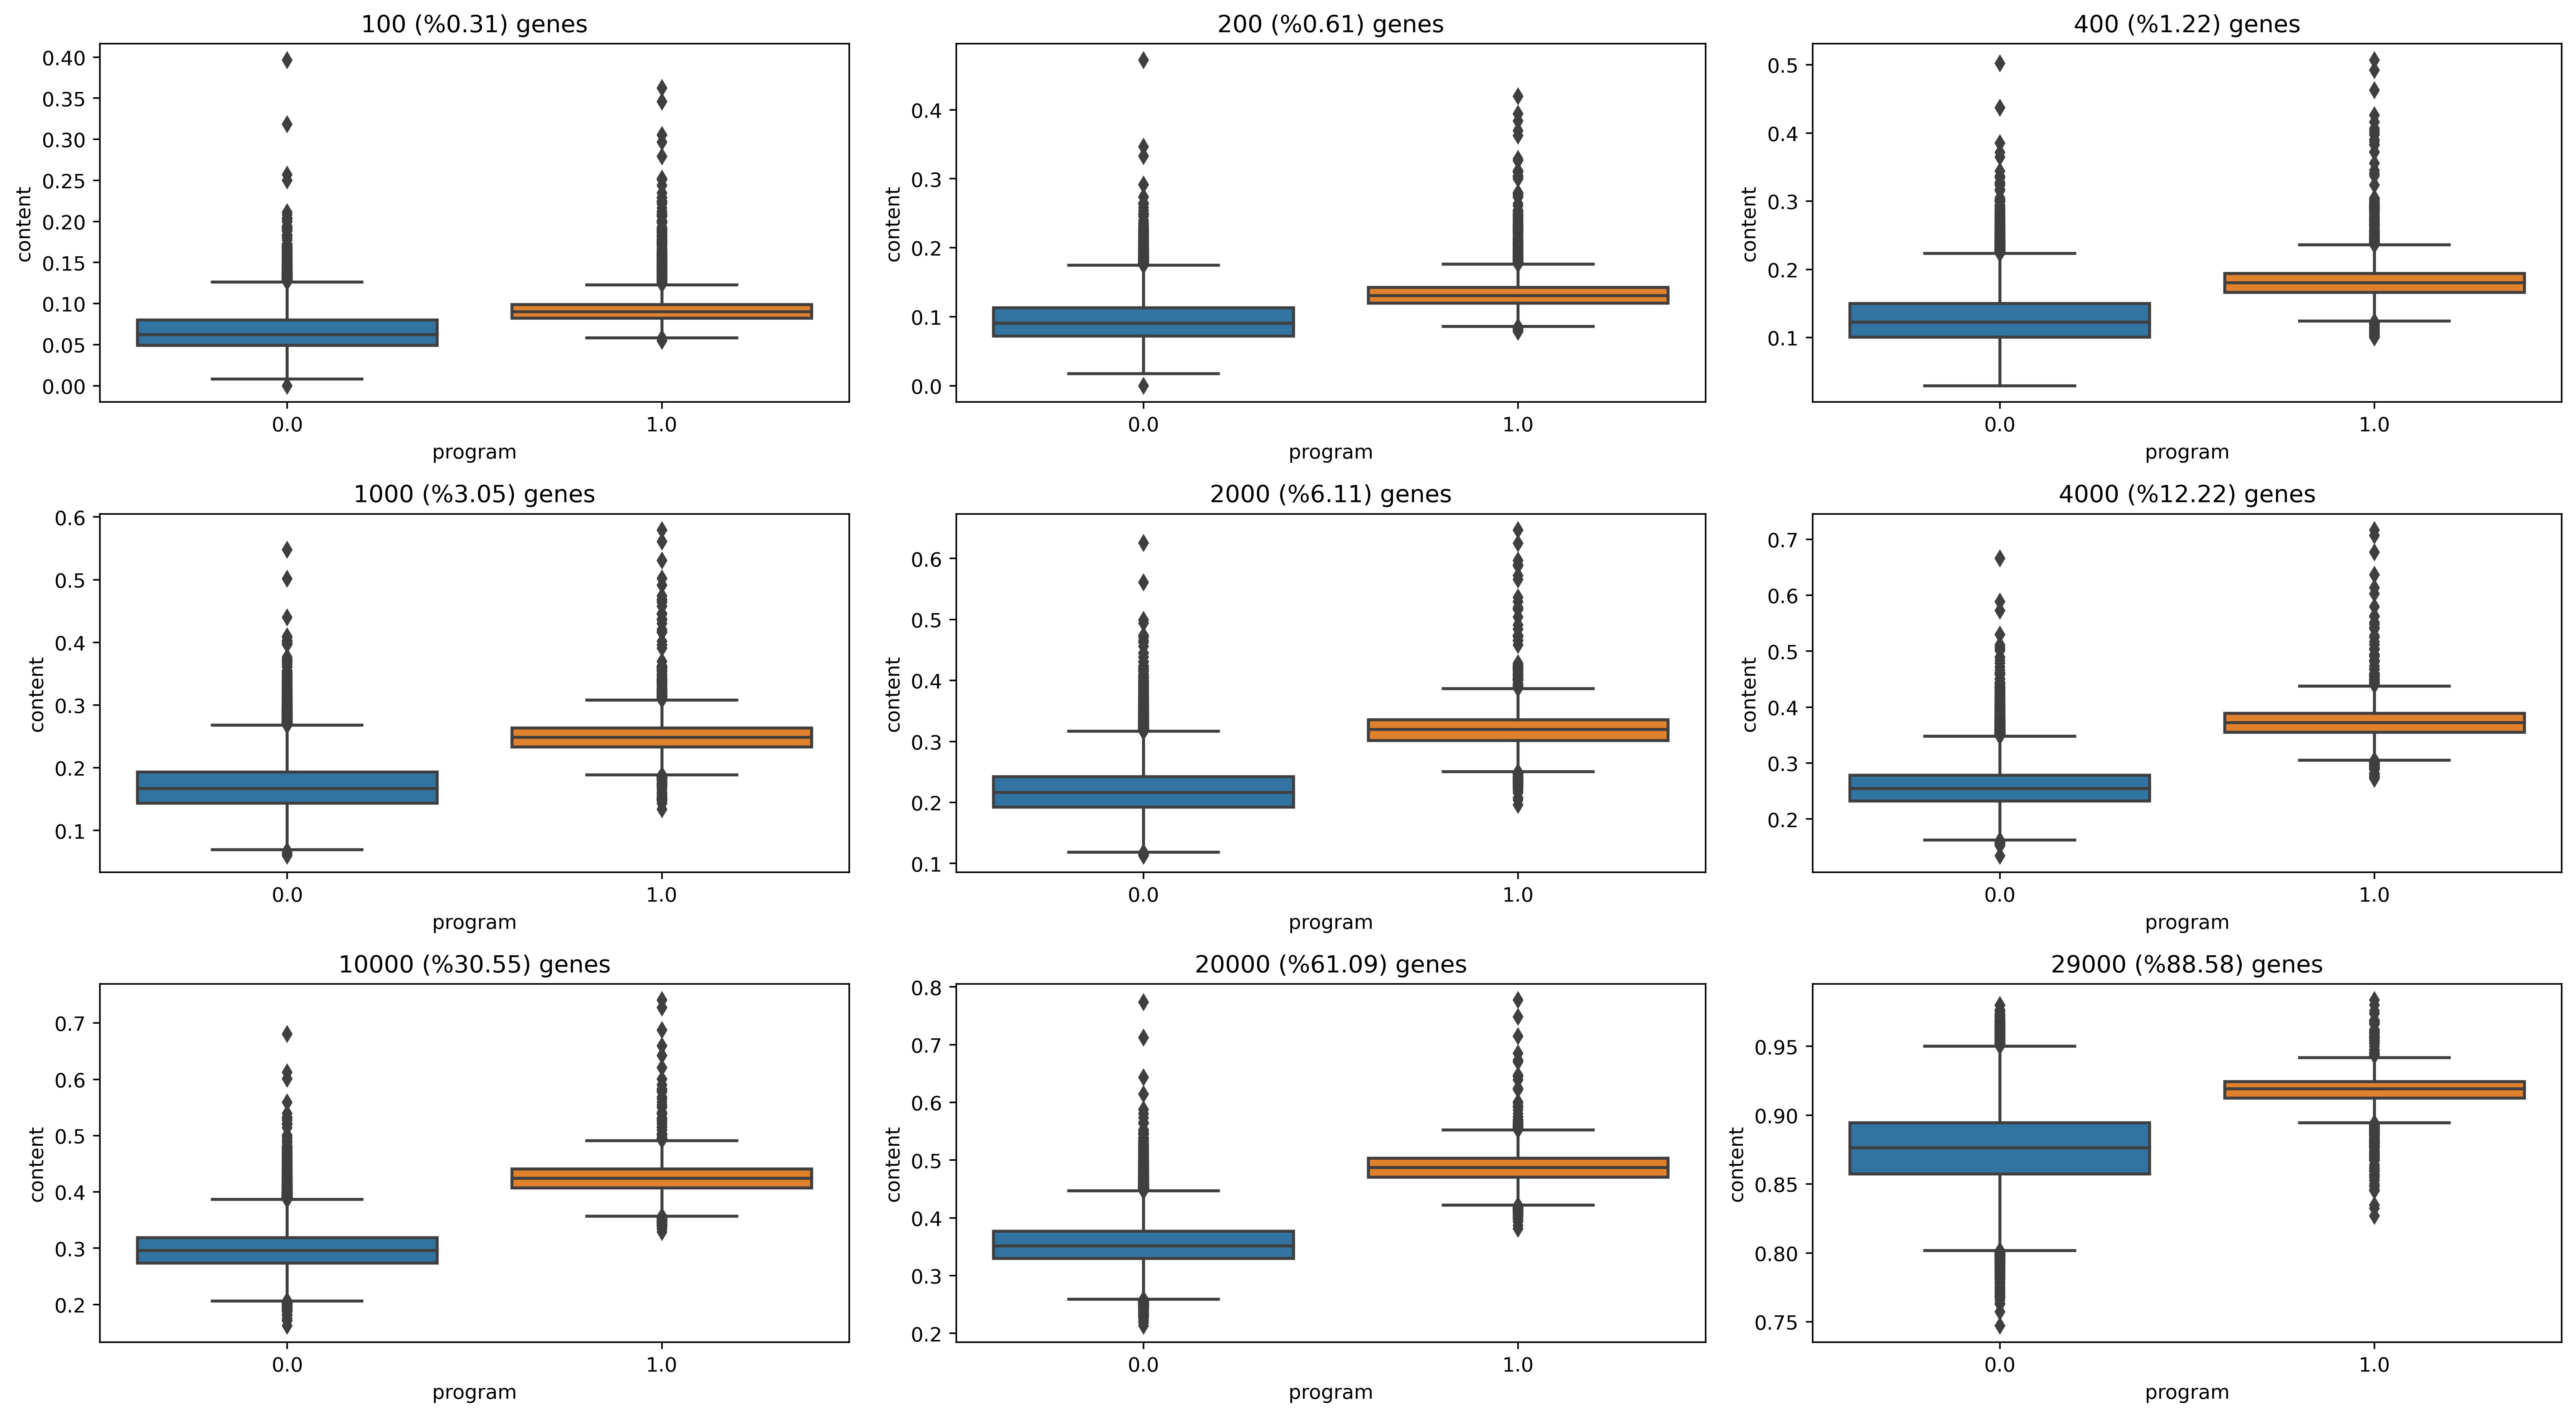

In [21]:
content_considered_list = [100, 200, 400, 1000, 2000, 4000, 10000, 20000, 29000]

plt.figure(figsize=(16,10));
# plt.figure(figsize=(16,56))
fig, axes = plt.subplots(int(np.ceil(len(content_considered_list)/3)), 3, figsize=(18, 10));
axes = axes.ravel();
axes_indices = [(x,y) for x in range(int(np.ceil(len(content_considered_list)/3))) for y in range(3)]

for idx, content_considered in enumerate(content_considered_list):
    
    if len(axes.shape)>1:
        ax = axes[axes_indices[idx][0], axes_indices[idx][1]]
    else:
        ax = axes[idx]
    

    highly_used_content = np.divide(np.sum(sample_cells_highly_express_program.counts[:, top_genes_indices[:content_considered]], axis=1), np.sum(sample_cells_highly_express_program.counts, axis=1))
    low_used_content = np.divide(np.sum(sample_cells_out_program.counts[:, top_genes_indices[:content_considered]], axis=1), np.sum(sample_cells_out_program.counts, axis=1))

    content_df = pd.DataFrame(transpose([highly_used_content, [1]*sample_cells_highly_express_program.number_of_cells]), columns=['content', 'program'])
    content_df = content_df.append(pd.DataFrame(transpose([low_used_content, [0]*sample_cells_out_program.number_of_cells]), columns=['content', 'program']))
    g = sns.boxplot(ax=ax, x="program", y="content", data=content_df)
    ax.set_title(f'{content_considered} (%{round((content_considered/tumor_cohort.number_of_genes)*100, 2)}) genes');
    
fig.tight_layout();

if len(content_considered_list)%3>0:
    for i in range(3-len(content_considered_list)%3, 0, -1):
        axes[-i].remove();


**Part2: boxplots displaying top genes expression of a given program**

<Figure size 6400x4000 with 0 Axes>

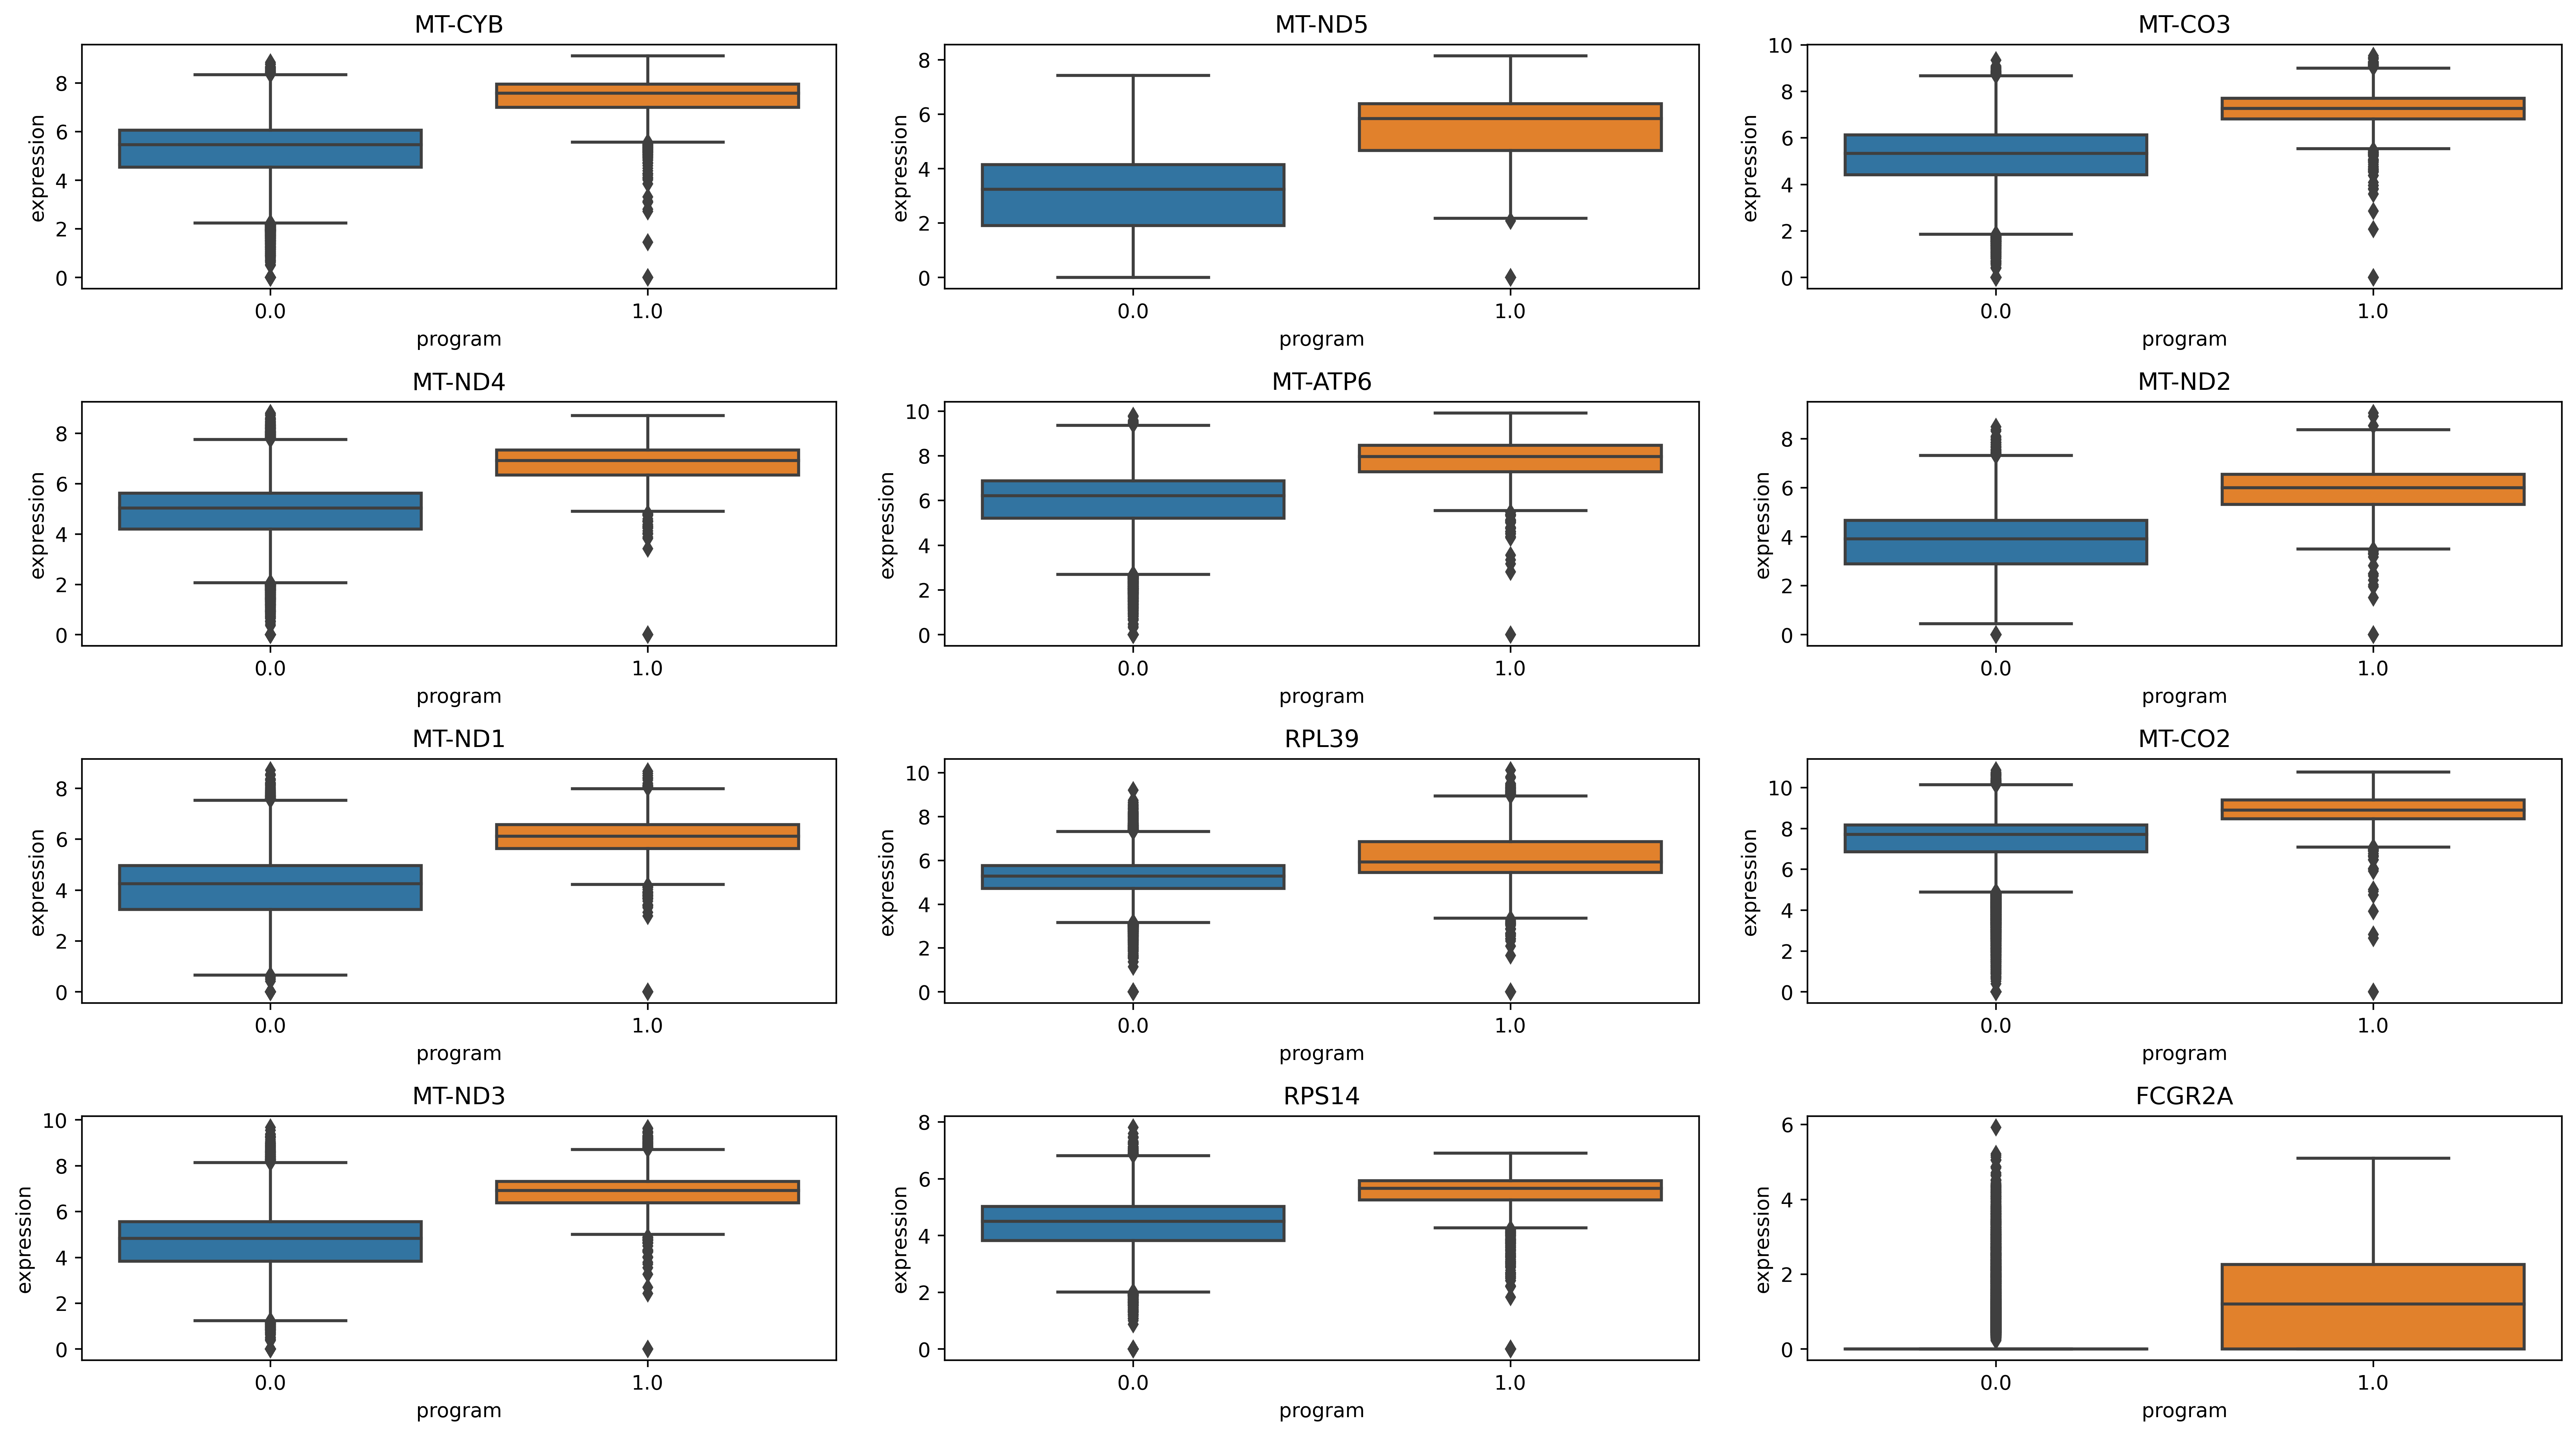

In [22]:
num_top_genes=12

top_genes_in_program = pd.Series(gene_scores[GEP].sort_values(ascending=False).index[:num_top_genes]).tolist()
plt.figure(figsize=(16,10));
# plt.figure(figsize=(16,56))
fig, axes = plt.subplots(int(np.ceil(len(top_genes_in_program)/3)), 3, figsize=(18, 10));
axes = axes.ravel();
axes_indices = [(x,y) for x in range(int(np.ceil(len(top_genes_in_program)/3))) for y in range(3)]

for idx, marker_name in enumerate(top_genes_in_program):
    
    if len(axes.shape)>1:
        ax = axes[axes_indices[idx][0], axes_indices[idx][1]]
    else:
        ax = axes[idx]
    
    
    gene_index = tumor_cohort.gene_names.index(marker_name)
    marker_df = pd.DataFrame(transpose([sample_cells_highly_express_program.counts[:, gene_index], [1]*sample_cells_highly_express_program.number_of_cells]), columns=['expression', 'program'])
    marker_df = marker_df.append(pd.DataFrame(transpose([sample_cells_out_program.counts[:, gene_index], [0]*sample_cells_out_program.number_of_cells]), columns=['expression', 'program']))
    
    
    g = sns.boxplot(ax=ax, x="program", y="expression", data=marker_df);
    ax.set_title(marker_name);
fig.tight_layout();

if len(top_genes_in_program)%3>0:
    for i in range(3-len(top_genes_in_program)%3, 0, -1):
        axes[-i].remove();


# Display correlation with response

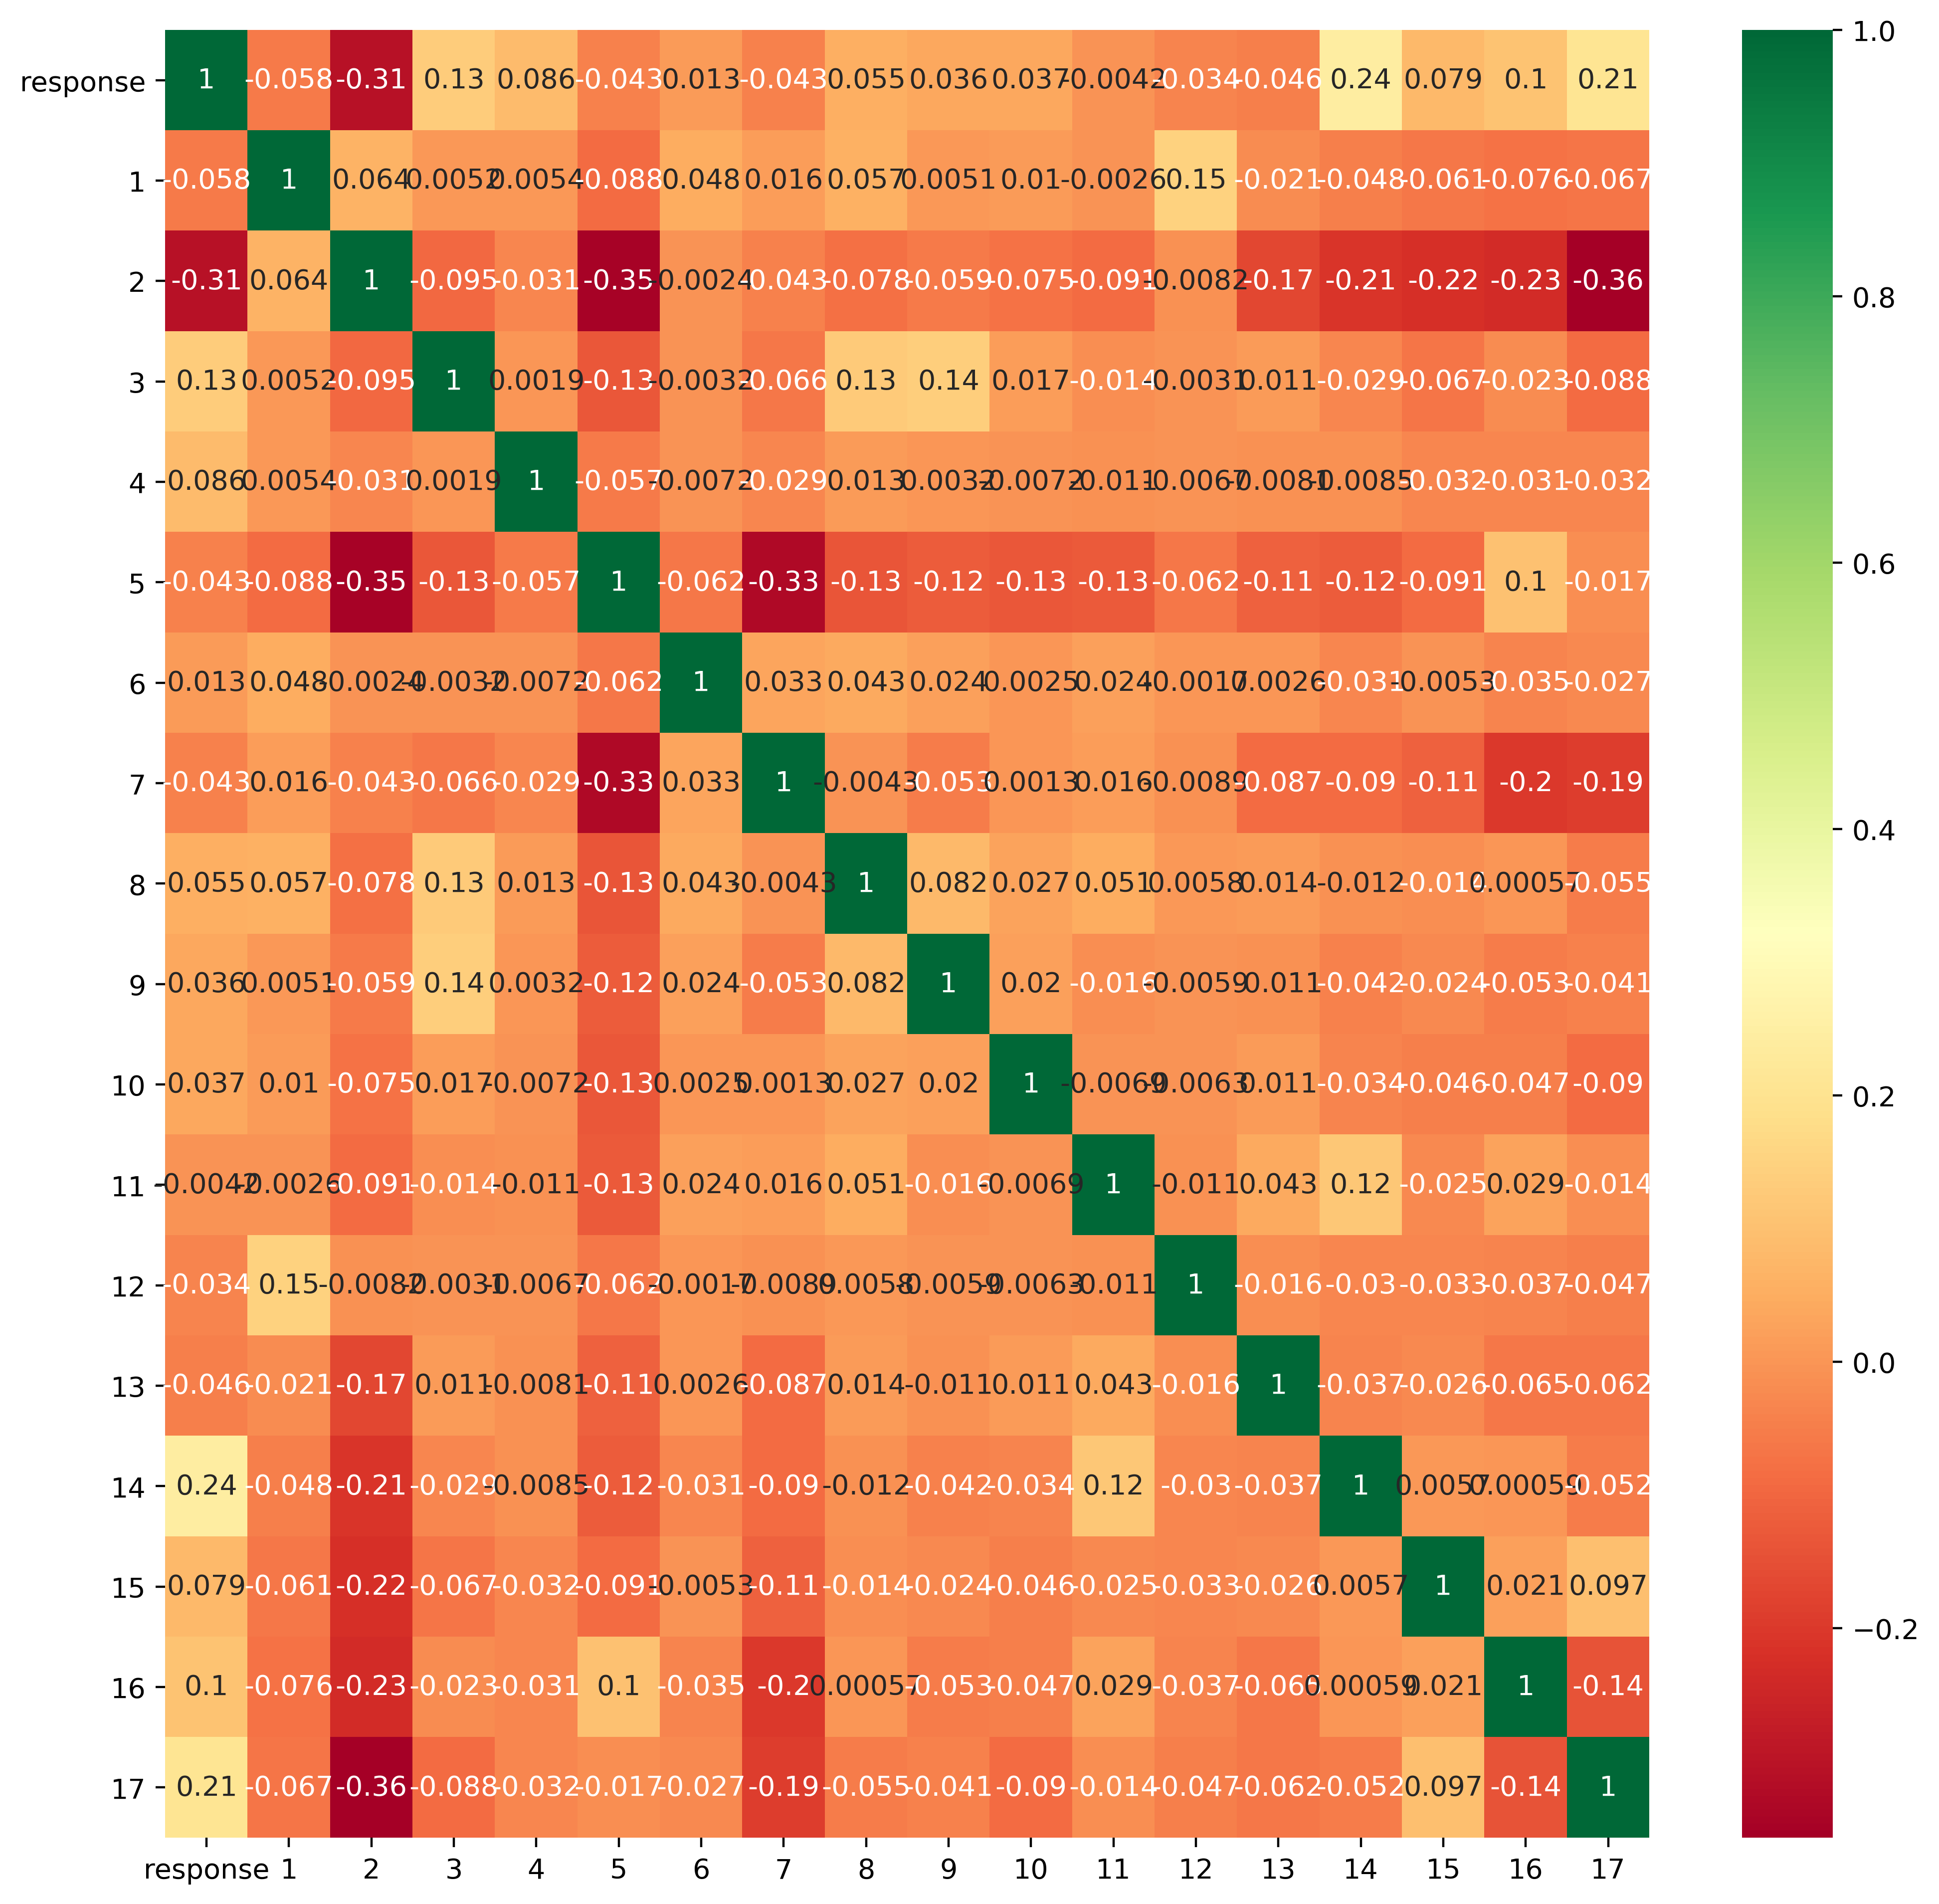

In [23]:
# taks normalized_usage_matrix and change id of df
usage_matrix = normalized_usage_matrix.copy()
usage_matrix['sample'] = [uu.split('_')[0] for uu in list(usage_matrix.index)]
usage_matrix['barcode'] = [uu.split('_')[1] for uu in list(usage_matrix.index)]
usage_matrix = usage_matrix.set_index(['sample', 'barcode']).reset_index()

# Loads xlsx files
CLINICAL_LABELS_PATH = r'/storage/md_keren/shitay/Data/tables/clinical_labels.xlsx'
MELANOMA_CLINICAL_DATA_PATH = r'/storage/md_keren/shitay/Data/tables/edited_unprotected_Melanoma_clinical_data.xlsx'
melanoma_clinical_data = pd.read_excel(MELANOMA_CLINICAL_DATA_PATH)
clinical_labels = pd.read_excel(CLINICAL_LABELS_PATH)

# takes nly first 46 samples, fill Nan and creat dictionary mapping
melanoma_clinical_data = melanoma_clinical_data.iloc[:46,:][['Patient id', 'Clinical response']]
melanoma_clinical_data['Clinical response'] = melanoma_clinical_data['Clinical response'].fillna('??')
labels_mapping = {v[0]: v[1] for v in clinical_labels[['Clinical response', 'binary label']].values}

# adds CRITERIA response into clinical df
melanoma_clinical_data['response'] = melanoma_clinical_data['Clinical response'].apply(lambda x: labels_mapping[x])

# merge clinical df with programs df to get response
usage_matrix_with_labels = pd.merge(usage_matrix, melanoma_clinical_data, how='left', left_on='sample', right_on='Patient id')

# remove samples that don't have response value yet
usage_matrix_with_labels = usage_matrix_with_labels[usage_matrix_with_labels['response'] != 'not in use for now']

# change response str values to int
usage_matrix_with_labels['response'] = usage_matrix_with_labels['response'].apply(lambda x: 0 if x=='NR' else 1)

# Print the number of response cells vs. number of non-response cells
# print(df_with_labels.groupby('response').count().reset_index().iloc[:,:2])

# Before calculating correlation, drop all unnecessary columns
programs_and_labels = usage_matrix_with_labels.drop(['sample', 'barcode', 'Patient id', 'Clinical response'],axis=1)

# change order of columns to have 'response' as the first one
programs_and_labels = programs_and_labels[programs_and_labels.columns.tolist()[-1:] + programs_and_labels.columns.tolist()[:-1]]

# calculates correlation
correlations = programs_and_labels.corr()

#plot heat map
plt.figure(figsize=(12,12))
g=sns.heatmap(correlations,annot=True,cmap="RdYlGn")

In [24]:
# g.get_figure().savefig(fr'/storage/md_keren/shitay/outputs/cNMF/visualizations/k{selected_K}/GEP_correlations.jpg')

#  ML 

In [51]:
# usage_matrix_with_labels #.drop(['sample', 'barcode', 'Patient id', 'Clinical response', 'response'], axis=1)

In [123]:
def train_model_and_predict(model, p_train, n_iter):
    samples = usage_matrix_with_labels['sample'].unique().tolist()
    cells_accuracies = []
    cells_recall = []
    cells_precision = []
    
    patients_accuracies = []
    patients_recall = []
    patients_precision = []
    


    for i in range(n_iter):
    #     print()
    #     print(f'{i+1}/{n_iter}', end=' ')
        train_samples = random.sample(samples, int(np.floor(len(samples)*p_train)))
        test_samples = [sample for sample in samples if not sample in train_samples]

    #     print('test')
    #     display(melanoma_clinical_data[melanoma_clinical_data['Patient id'].apply(lambda x: x in test_samples)]['response'].value_counts())
    #     print('train')
    #     display(melanoma_clinical_data[melanoma_clinical_data['Patient id'].apply(lambda x: x in train_samples)]['response'].value_counts())

        # First, define which variables are the features and which are the labels
        usage_matrix_with_labels
        train_df = usage_matrix_with_labels[usage_matrix_with_labels['Patient id'].apply(lambda x: x in train_samples)]
        X_train = train_df.drop(['sample', 'barcode', 'Patient id', 'Clinical response', 'response'], axis=1).values
        Y_train = train_df['response'].values

        test_df = usage_matrix_with_labels[usage_matrix_with_labels['Patient id'].apply(lambda x: x in test_samples)]
        X_test = test_df.drop(['sample', 'barcode', 'Patient id', 'Clinical response', 'response'], axis=1).values
        Y_test = test_df['response'].values
    
        # finally, train a classifier 
        
        model.fit(X_train, Y_train)


        # check our predictions!
        predictions = model.predict(X_test)
    #     print("classifier predictions for test set: \n", predictions)
    #     print("true labels for test set: \n", Y_test)
    #     print("The classifier's accuracy is:", np.count_nonzero(predictions == Y_test)/len(Y_test))
        cells_accuracies.append(accuracy_score(Y_test, predictions))
        cells_recall.append(recall_score(Y_test, predictions))
        cells_precision.append(precision_score(Y_test, predictions))

        predictions
        df = test_df.copy()[['sample', 'response']]
        df['pred'] = predictions
        df = df.groupby('sample').mean().reset_index()
        df['pred patient'] = np.round(df['pred'])
    #     print(f'acurracy patient:\t\t{sum(df["response"] == df["pred patient"]) / len(df)}')
#         patients_accuracies.append(sum(df["response"] == df["pred patient"]) / len(df))
        patients_accuracies.append(accuracy_score(df["response"].tolist(), df["pred patient"].tolist()))
        patients_recall.append(recall_score(df["response"].tolist(), df["pred patient"].tolist()))
        patients_precision.append(precision_score(df["response"].tolist(), df["pred patient"].tolist()))
        
    return cells_accuracies, cells_recall, cells_precision, patients_accuracies, patients_recall, patients_precision

Working on KNN
Working on RF
Working on SVM


Text(0.5, 1.0, 'Predicting response via program vectors, 25 iterations each model')

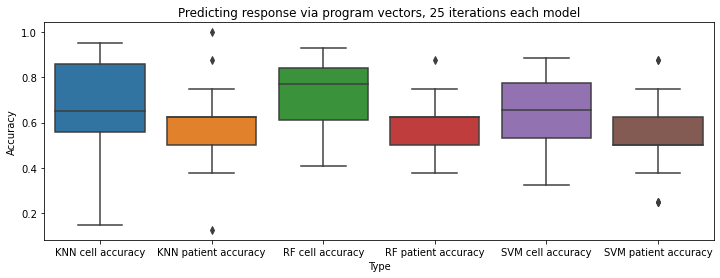

In [85]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# KNN with n=20
n_neighbors = 20
n_iter = 25


knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)  # n_neighbors is the number of neighbors to use for classification
print('Working on KNN')
cells_accuracies, patients_accuracies = train_model_and_predict(knn_classifier, p_train, n_iter)

accuracy_df = pd.DataFrame(transpose([cells_accuracies, ['KNN cell accuracy']*n_iter]), columns=['Accuracy', 'Type'])
accuracy_df = accuracy_df.append(pd.DataFrame(transpose([patients_accuracies, ['KNN patient accuracy']*n_iter]), columns=['Accuracy', 'Type']))

# Random forest with dph 6
rf_classifier = RandomForestClassifier(max_depth=6, random_state=0)
print('Working on RF')
cells_accuracies, patients_accuracies = train_model_and_predict(rf_classifier, p_train, n_iter)

accuracy_df = accuracy_df.append(pd.DataFrame(transpose([cells_accuracies, ['RF cell accuracy']*n_iter]), columns=['Accuracy', 'Type']))
accuracy_df = accuracy_df.append(pd.DataFrame(transpose([patients_accuracies, ['RF patient accuracy']*n_iter]), columns=['Accuracy', 'Type']))

# SVM
svm = svm.SVC()
print('Working on SVM')
cells_accuracies, patients_accuracies = train_model_and_predict(svm, p_train, n_iter)
accuracy_df = accuracy_df.append(pd.DataFrame(transpose([cells_accuracies, ['SVM cell accuracy']*n_iter]), columns=['Accuracy', 'Type']))
accuracy_df = accuracy_df.append(pd.DataFrame(transpose([patients_accuracies, ['SVM patient accuracy']*n_iter]), columns=['Accuracy', 'Type']))

accuracy_df['Accuracy'] = accuracy_df['Accuracy'].astype(np.float)
# sns.set(font_scale=0.2)  # crazy big
# plt.rc_file_defaults()
# sns.reset_orig()
g = sns.boxplot(x="Type", y="Accuracy", data=accuracy_df);
# g = sns.boxplot(run1, orient="v");
g.figure.set_figwidth(12)
# g.figure.set_figheight(2)
g.set_title(f'Predicting response via program vectors, {n_iter} iterations each model')

Working on KNN


/Local/md_keren/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Local/md_keren/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Local/md_keren/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Local/md_keren/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification

Working on RF


/Local/md_keren/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Local/md_keren/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Local/md_keren/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Local/md_keren/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification

Working on SVM


/Local/md_keren/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Local/md_keren/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


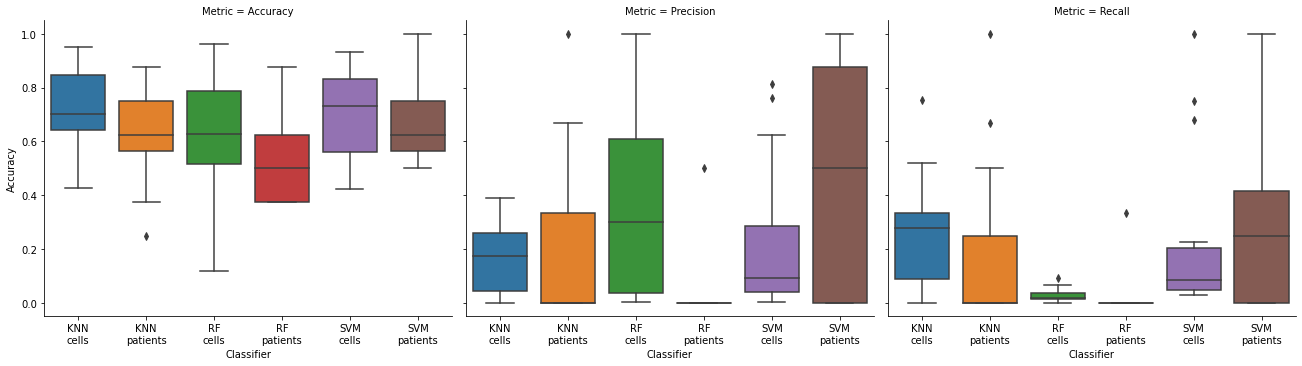

In [151]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

# KNN with n=20
n_neighbors = 20
n_iter = 15


knn_classifier = KNeighborsClassifier(n_neighbors=n_neighbors)  # n_neighbors is the number of neighbors to use for classification
print('Working on KNN')
cells_accuracies, cells_recall, cells_precision, patients_accuracies, patients_recall, patients_precision = train_model_and_predict(knn_classifier, p_train, n_iter)

# add accuracy
df = pd.DataFrame(transpose([cells_accuracies, ['KNN\ncells']*n_iter, ['Accuracy']*n_iter]), columns=['Accuracy', 'Classifier', 'Metric'])
df = df.append(pd.DataFrame(transpose([patients_accuracies, ['KNN\npatients']*n_iter, ['Accuracy']*n_iter]), columns=['Accuracy', 'Classifier', 'Metric']))
# add precision
df = df.append(pd.DataFrame(transpose([cells_precision, ['KNN\ncells']*n_iter, ['Precision']*n_iter]), columns=['Accuracy', 'Classifier', 'Metric']))
df = df.append(pd.DataFrame(transpose([patients_precision, ['KNN\npatients']*n_iter, ['Precision']*n_iter]), columns=['Accuracy', 'Classifier', 'Metric']))
# add recall 
df = df.append(pd.DataFrame(transpose([cells_recall, ['KNN\ncells']*n_iter, ['Recall']*n_iter]), columns=['Accuracy', 'Classifier', 'Metric']))
df = df.append(pd.DataFrame(transpose([patients_recall, ['KNN\npatients']*n_iter, ['Recall']*n_iter]), columns=['Accuracy', 'Classifier', 'Metric']))




# Random forest with dph 6
rf_classifier = RandomForestClassifier(max_depth=6, random_state=0)
print('Working on RF')
cells_accuracies, cells_recall, cells_precision, patients_accuracies, patients_recall, patients_precision = train_model_and_predict(rf_classifier, p_train, n_iter)

# add accuracy
df = df.append(pd.DataFrame(transpose([cells_accuracies, ['RF\ncells']*n_iter, ['Accuracy']*n_iter]), columns=['Accuracy', 'Classifier', 'Metric']))
df = df.append(pd.DataFrame(transpose([patients_accuracies, ['RF\npatients']*n_iter, ['Accuracy']*n_iter]), columns=['Accuracy', 'Classifier', 'Metric']))
# add precision
df = df.append(pd.DataFrame(transpose([cells_precision, ['RF\ncells']*n_iter, ['Precision']*n_iter]), columns=['Accuracy', 'Classifier', 'Metric']))
df = df.append(pd.DataFrame(transpose([patients_precision, ['RF\npatients']*n_iter, ['Precision']*n_iter]), columns=['Accuracy', 'Classifier', 'Metric']))
# add recall 
df = df.append(pd.DataFrame(transpose([cells_recall, ['RF\ncells']*n_iter, ['Recall']*n_iter]), columns=['Accuracy', 'Classifier', 'Metric']))
df = df.append(pd.DataFrame(transpose([patients_recall, ['RF\npatients']*n_iter, ['Recall']*n_iter]), columns=['Accuracy', 'Classifier', 'Metric']))



# SVM
svm = svm.SVC()
print('Working on SVM')
cells_accuracies, cells_recall, cells_precision, patients_accuracies, patients_recall, patients_precision = train_model_and_predict(svm, p_train, n_iter)

#add accuracy
df = df.append(pd.DataFrame(transpose([cells_accuracies, ['SVM\ncells']*n_iter, ['Accuracy']*n_iter]), columns=['Accuracy', 'Classifier', 'Metric']))
df = df.append(pd.DataFrame(transpose([patients_accuracies, ['SVM\npatients']*n_iter, ['Accuracy']*n_iter]), columns=['Accuracy', 'Classifier', 'Metric']))
#add precision
df = df.append(pd.DataFrame(transpose([cells_precision, ['SVM\ncells']*n_iter, ['Precision']*n_iter]), columns=['Accuracy', 'Classifier', 'Metric']))
df = df.append(pd.DataFrame(transpose([patients_precision, ['SVM\npatients']*n_iter, ['Precision']*n_iter]), columns=['Accuracy', 'Classifier', 'Metric']))
# add recall 
df = df.append(pd.DataFrame(transpose([cells_recall, ['SVM\ncells']*n_iter, ['Recall']*n_iter]), columns=['Accuracy', 'Classifier', 'Metric']))
df = df.append(pd.DataFrame(transpose([patients_recall, ['SVM\npatients']*n_iter, ['Recall']*n_iter]), columns=['Accuracy', 'Classifier', 'Metric']))


df['Accuracy'] = df['Accuracy'].astype(np.float)
# sns.set(font_scale=0.2)  # crazy big
# plt.rc_file_defaults()
# sns.reset_orig()
# g = sns.boxplot(x="Type", y="Accuracy", data=df);
g = sns.catplot(x="Classifier", y="Accuracy", col="Metric", data=df, kind="box",height=5, aspect=1.2);
# g = sns.boxplot(run1, orient="v");
# g.figure.set_figwidth(12)
# g.figure.set_figheight(2)
# g.set_title(f'Predicting response via program vectors, {n_iter} iterations each model')
# g.fig.suptitle(f'Predicting response via program vectors, {n_iter} iterations each model')

# Plot 2 programs

In [51]:
prog_1 = 2
prog_2 = 16
resample = df_with_labels.sample(2000)
sns.relplot(data=resample, x=prog_1, y=prog_2, hue='response');

NameError: name 'df_with_labels' is not defined

# Print top genes of specified program

In [ ]:
topgenes = []
num_top_genes=50
for gep in gene_scores.columns:
    topgenes.append(pd.Series(gene_scores[gep].sort_values(ascending=False).index[:num_top_genes]))
    
topgenes = pd.concat(topgenes, axis=1)
topgenes.columns = ['GEP%d' % g for g in gene_scores.columns]

# topgenes

In [ ]:
# for g in topgenes["GEP19"].values.tolist():
#     print(g)

# DEBUG

In [1]:
# programs_vals = tsne_and_usages[2].values
# dict(Counter(np.round(programs_vals, 1)))

In [1]:
# for (columnName, columnData) in normalized_usage_matrix.iteritems():
#     print('Program : ', columnName)
#     programs_vals = columnData.values
#     counter_programs_values = sort_dic(dict(Counter(np.round(programs_vals, 1))), ascending=False)
#     print(counter_programs_values)
#     dd = list(counter_programs_values.values())
#     print([(i/10, round(sum(dd[i:]), 2)) for i in range(11)])
#     print()

In [ ]:
# print(counter_programs_values)

# # dd = list(counter_programs_values.values())
# # [(i/10, round(sum(dd[i:]), 2)) for i in range(11)]
# import seaborn as sns
# from utilities.general_helpers import sort_dic

# k = 18
# sns.distplot(np.round(tsne_and_usages[k].values, 1), hist=False)
# # list(np.round(programs_vals, 1))
# Counter(np.round(tsne_and_usages[k].values, 1))

In [ ]:
# tsne_and_usages.head()

In [ ]:
# programs_1 = tsne_and_usages[tsne_and_usages.columns[4]].values
# programs_1

In [ ]:
# len(list(tsne_and_usages.index))

In [ ]:
# def some_func(x):
#     return round(x*10)



# ttt = dict(Counter(tsne_and_usages[tsne_and_usages.columns[4]].apply(some_func).values))

# # fig, ax = plt.pyplot.subplots()    
# # ax.bar(list(ttt.keys()), list(ttt.values()))
# # for i, v in enumerate(list(ttt.values())):
# #     ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')

# print({k: v for k, v in sorted(ttt.items(), key=lambda item: item[0])})
# sum([vv for k, vv in ttt.items() if k>0])

In [ ]:
# barcodes = np.array(tsne_and_usages.index.tolist())

In [ ]:
# order = np.flip(np.argsort(programs_1))
# barcodes[order][:10]
# # programs_1[order][:10]


# DEBUG

In [37]:
# overdis_genes = [line.replace('\n', '') for line in lines]
# overdis_genes[-10:]
# path2 = r'/storage/md_keren/shitay/Data/tables/gene_ens_map.xlsx'
# ex = pd.read_excel(path2)
# ex_genes = ex[ex['long_noncoding']=='protein_coding']['MIR1302-11'].values.tolist()
[g for g in overdis_genes if not g in ex_genes]

['TMEM236.1', 'PSMA2.1']

In [34]:
path = r'/storage/md_keren/shitay/outputs/cNMF/executions/tumor_runs/cohort_26.6.21/k5_14_2000genes_10iter/k5_14_2000genes_10iter.overdispersed_genes.txt'

with open(path) as f:
    lines = f.readlines()

In [7]:
overdis_genes = [line.replace('\n', '') for line in lines]
overdis_genes[-10:]

['RP11-290D2.6',
 'CTA-384D8.34',
 'RP11-386I14.4',
 'RP5-899E9.1',
 'RP11-268E23.2',
 'RP11-480C22.1',
 'RP4-539M6.22',
 'RP11-1399P15.1',
 'RP11-108L7.14',
 'RP11-80H18.4']

In [11]:
path2 = r'/storage/md_keren/shitay/Data/tables/gene_ens_map.xlsx'
ex = pd.read_excel(path2)

In [21]:
ex_genes = ex[ex['long_noncoding']=='protein_coding']['MIR1302-11'].values.tolist()

In [24]:
len(overdis_genes)
len(ex_genes)

20776

In [26]:
len([g for g in overdis_genes if g in ex_genes])

1423

In [31]:
[g1.split('.')[0] for g1 in overdis_genes]

['FGR',
 'CFH',
 'CFTR',
 'TFPI',
 'CD38',
 'PDK4',
 'SLC4A1',
 'ITGAL',
 'ASB4',
 'CCL18',
 'CCL3',
 'LGALS14',
 'SELE',
 'IL32',
 'MASP2',
 'TRAF3IP3',
 'CD9',
 'HHATL',
 'SEMA3G',
 'STAB1',
 'SLC6A7',
 'DCN',
 'TYROBP',
 'ALOX5',
 'CLDN11',
 'CD6',
 'WAS',
 'STMN4',
 'IGF1',
 'SLC11A1',
 'MARCO',
 'CD74',
 'C8B',
 'BIRC3',
 'VIM',
 'IBSP',
 'TMSB10',
 'MYOC',
 'STAP1',
 'FLT4',
 'VCAN',
 'MSR1',
 'TNC',
 'C2orf83',
 'CAPG',
 'ADAM28',
 'TNFRSF17',
 'UTS2',
 'TNFRSF9',
 'ELN',
 'TNIP3',
 'ITIH1',
 'SERPINB3',
 'SLC2A3',
 'GNA15',
 'VMP1',
 'WISP2',
 'NGFR',
 'BCAS1',
 'CALCRL',
 'SLC9A3R2',
 'COL17A1',
 'CD84',
 'SPI1',
 'FGFR2',
 'ACSM2B',
 'KLF6',
 'PKM',
 'GPR116',
 'SCT',
 'DAPP1',
 'PABPC1',
 'EPHA8',
 'SPP2',
 'TRPC5',
 'DHRS9',
 'CD5L',
 'PTGS2',
 'TBX21',
 'NOTCH3',
 'IPCEF1',
 'ENO1',
 'ACTB',
 'ATP12A',
 'ARHGAP15',
 'NMRK2',
 'APBB1IP',
 'FBLN1',
 'CST7',
 'EDN1',
 'P2RY10',
 'SP140',
 'DCT',
 'COL5A3',
 'CLDND1',
 'CFHR2',
 'CXCL2',
 'LRP2',
 'OPRK1',
 'EPYC',
 'GSTP1',
 

In [ ]:
# gene_indices = np.flip(np.argsort(tumor_cohort.counts[tumor_cohort.barcodes.index('CTACCCAAGATGCCTT-1')]))

# tumor_cohort.gene_names[gene_indices[6]]

In [ ]:

# # tumor_cohort.gene_names.index('CD3E')
# tumor_cohort.number_of_genes

In [ ]:
# tumor_path = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/tumor_cells.pkl'
# tumor_cohort = pickle.load(open(tumor_path, 'rb'))

In [ ]:
# idx = tumor_cohort.gene_names.index('CD3E')

# tumor_cohort.counts[tumor_cohort.barcodes.index('GCTGCAGGTACAGTTC-1')][idx]

In [ ]:
# tumor_cohort.samples[tumor_cohort.barcodes.index('GCTGCAGGTACAGTTC-1')]

In [ ]:
# gene_idx = tumor_cohort.gene_names.index('FOXP3')
# cell_idx = tumor_cohort.barcodes.index('GGCGTGTTCAGGATCT-1')
# tumor_cohort.counts[cell_idx][gene_idx]
# tumor_cohort.cells_information[cell_idx].cancer_immune_conflict

In [ ]:
# sum(tumor_cohort.cells_information.getattr('is_doublet'))

In [ ]:
# sum(tumor_cohort.cells_information.getattr('should_be_removed'))

In [ ]:
# cohort_path = r'/storage/md_keren/shitay/Data/droplet_seq/cohort/normalized/cohort.pkl'
# cohort = pickle.load(open(tumor_path, 'rb'))

In [ ]:
# is_doublet = cohort.cells_information.getattr('is_doublet')
# cohort.samples
# sum(is_doublet)

# Counter([cohort.samples[ii] for ii in range(len(cohort.samples)) if is_doublet[ii]])

In [81]:
prog_genes = ['MT-CYB', 'MT-ND5', 'MT-CO3', 'MT-ND4', 'MT-ATP6', 'MT-ND2', 'MT-ND1', 'RPL39', 'MT-CO2', 'MT-ND3', 'RPS14', 'FCGR2A', 'MT-ATP8', 'FXYD3', 'RPL15', 'RPL23A', 'SIGLEC15', 'MT-CO1', 'TPT1', 'RPS4Y1', 'MT-ND4L', 'RPS23', 'CHL1', 'RPL32', 'SPRY4', 'TOMM7', 'RPL14', 'CHCHD6', 'RPL37', 'RPL35A', 'FASN', 'PSCA', 'HPN-AS1', 'ALDH1A3', 'ERBB3', 'RP11-542A14.1', 'ATP1B1', 'AEBP1', 'RPL34', 'RPL4', 'RPLP1', 'RPL22', 'SFRP1', 'ANKS1A', 'TMEM163', 'RPL37A', 'RPL10A', 'DNASE2B', 'F2RL2', 'NSA2', 'RPSA', 'RPS8', 'TYR', 'UGCG', 'CYTH3', 'TEKT5', 'RPS21', 'GJB1', 'APCDD1', 'RPL11', 'SLAMF1', 'PEG10', 'RPL13A', 'RPL10', 'GRIA1', 'SNCA', 'EDNRB', 'IQGAP2', 'RPL36A', 'LPPR4', 'PTTG1IP', 'PYCARD', 'TCERG1L', 'SEMA5A', 'RPS16', 'ETV5', 'PLEKHB1', 'RPL24', 'RPL9', 'LINC00890', 'PDE3B', 'RPS3', 'RPL29', 'MCOLN3', 'SHISA2', 'RP11-542A14.2', 'LINC01088']
